### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import matplotlib.pyplot as plt
import gc
import numpy as np
import os
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.constants import (
    PROCESSED_DATA_PATH
)
from utils.feature_engineering_helpers import integerize

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

In [7]:
START = time.time()

### Read Data

In [8]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train_psr.parquet", replace_negative127=True)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test_psr.parquet", replace_negative127=True)

Shape of data: (5531451, 193)
Shape of data: (11363762, 192)
CPU times: user 17.1 s, sys: 23.6 s, total: 40.7 s
Wall time: 28.4 s


In [9]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 258 ms, sys: 27.4 ms, total: 285 ms
Wall time: 293 ms


### B_1

0 null count, 0.000 null proportion
nan of the targets have label = 1


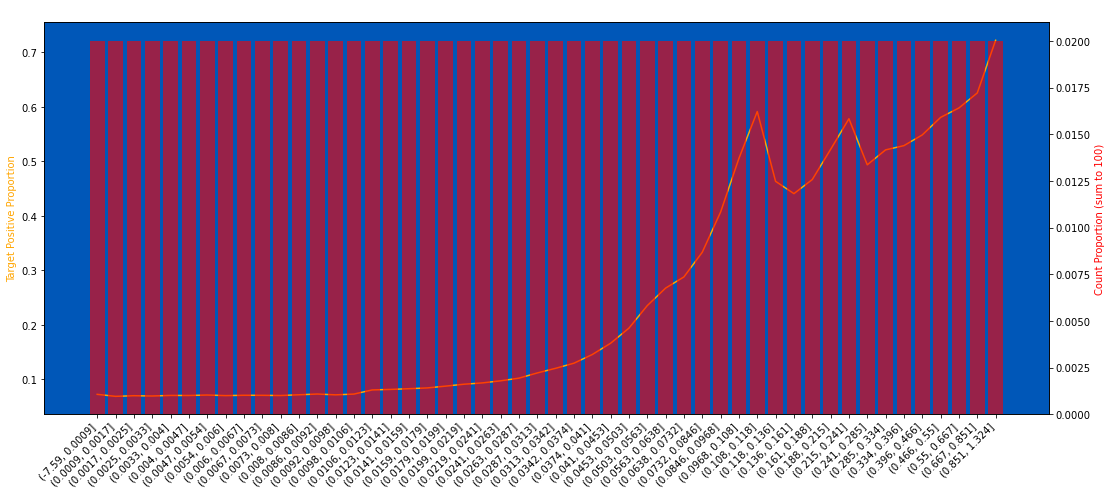

In [10]:
plot_target_check(train, "B_1", q=50, use_raw_bin=True)

In [11]:
train["B_1"] = train["B_1"].round(2)
test["B_1"] = test["B_1"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


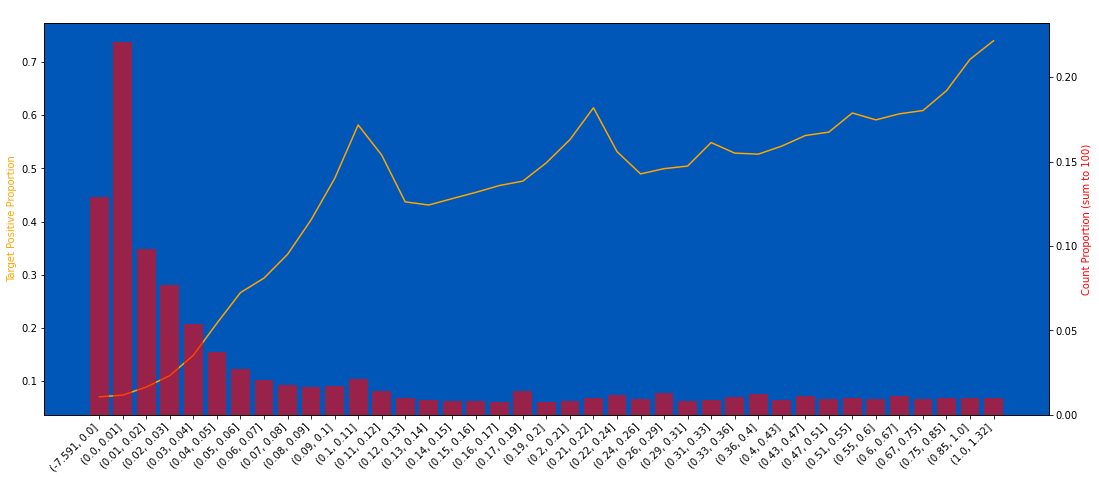

In [12]:
plot_target_check(train, "B_1", q=100, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


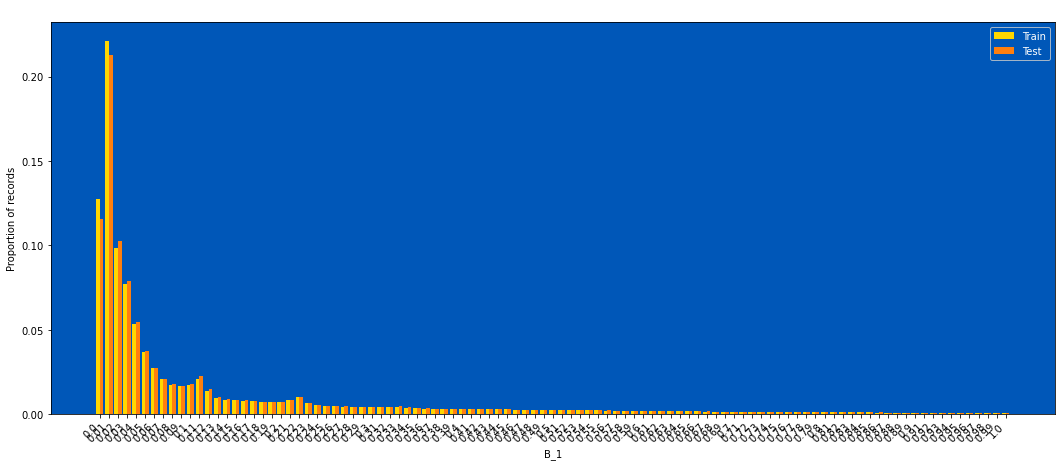

In [13]:
plot_train_test_distribution(train, test, "B_1", nunique_thr=8000)

### B_2

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


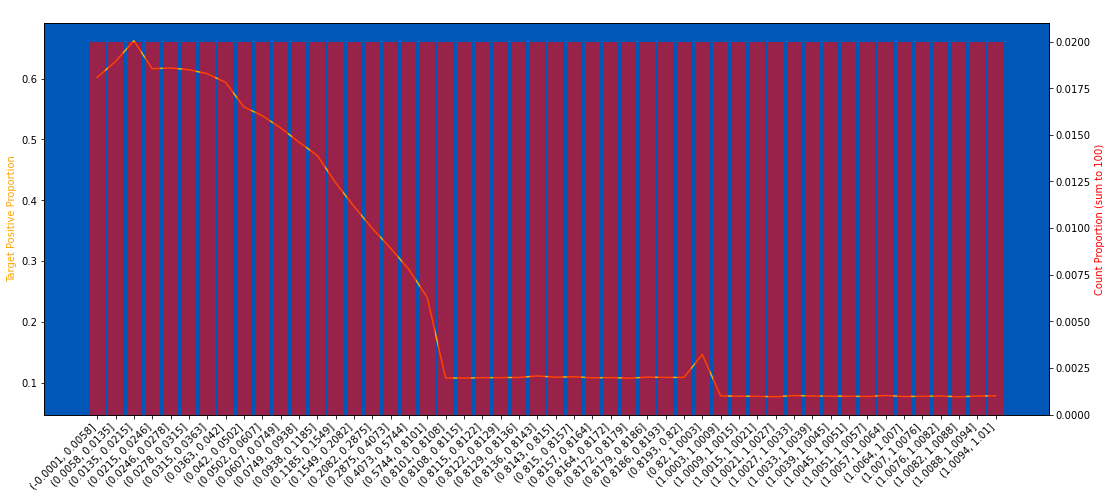

In [14]:
plot_target_check(train, "B_2", q=50, use_raw_bin=True)

In [15]:
train["B_2"] = train["B_2"].round(2)
test["B_2"] = test["B_2"].round(2)

In [16]:
train.loc[train["B_2"].between(1, 1.01), "B_2"] = 1
test.loc[test["B_2"].between(1, 1.01), "B_2"] = 1

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


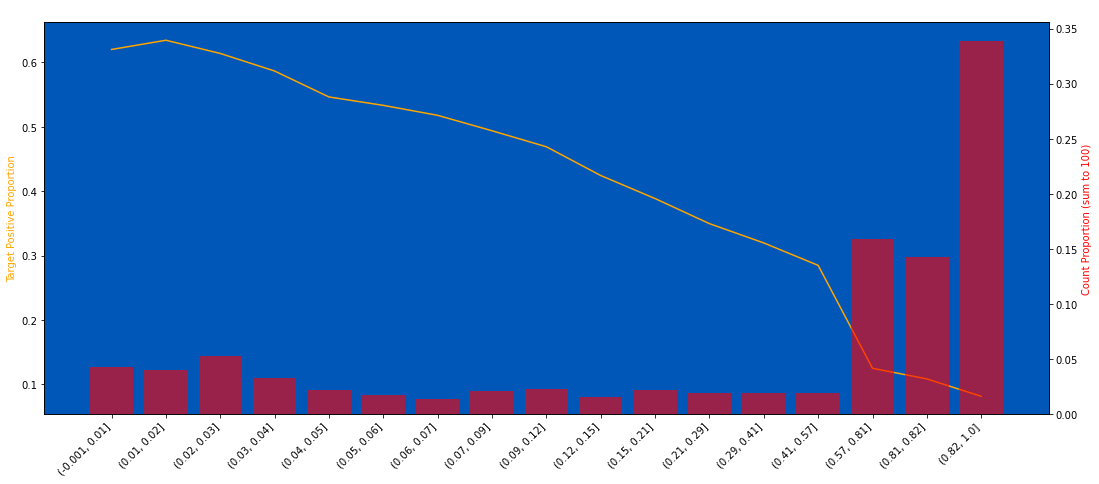

In [17]:
plot_target_check(train, "B_2", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


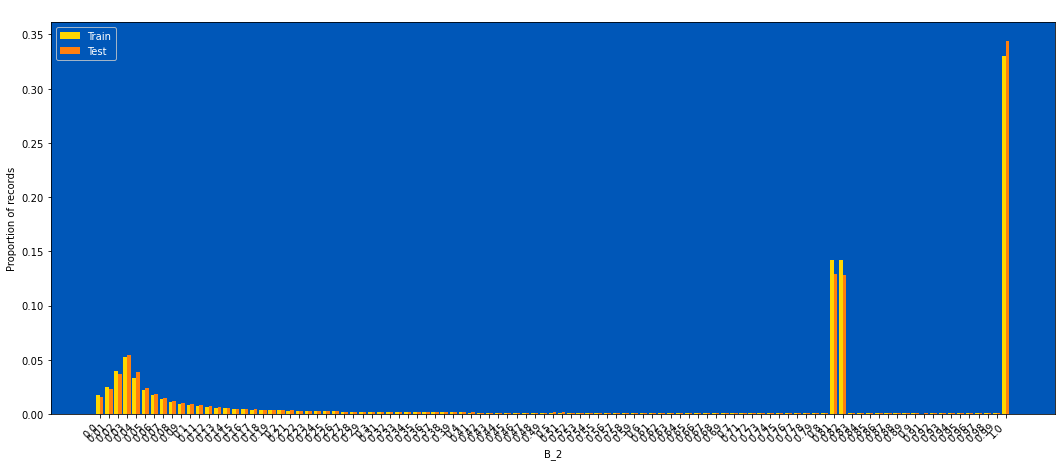

In [18]:
plot_train_test_distribution(train, test, "B_2", nunique_thr=8000)

### B_3

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


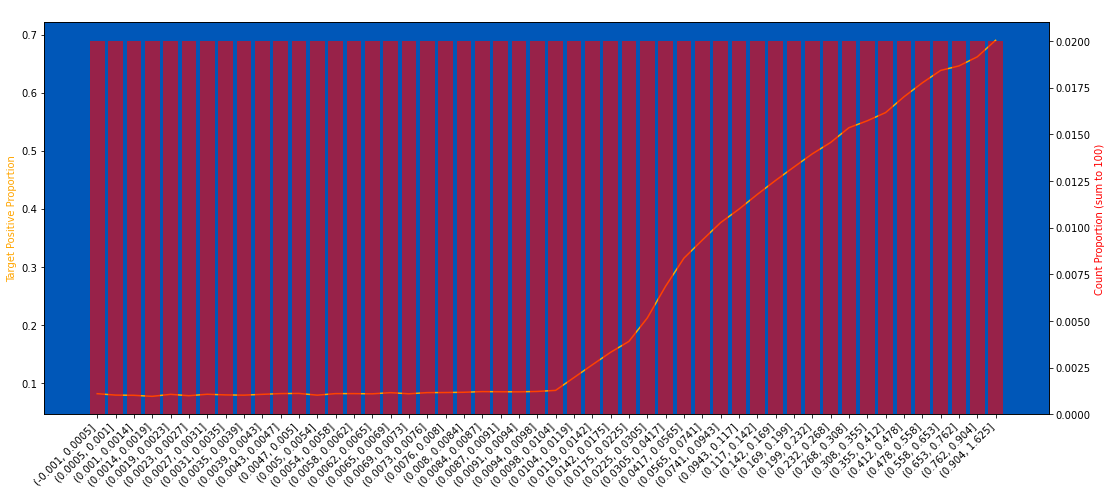

In [19]:
plot_target_check(train, "B_3", q=50, use_raw_bin=True)

In [20]:
train["B_3"] = train["B_3"].round(2)
test["B_3"] = test["B_3"].round(2)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


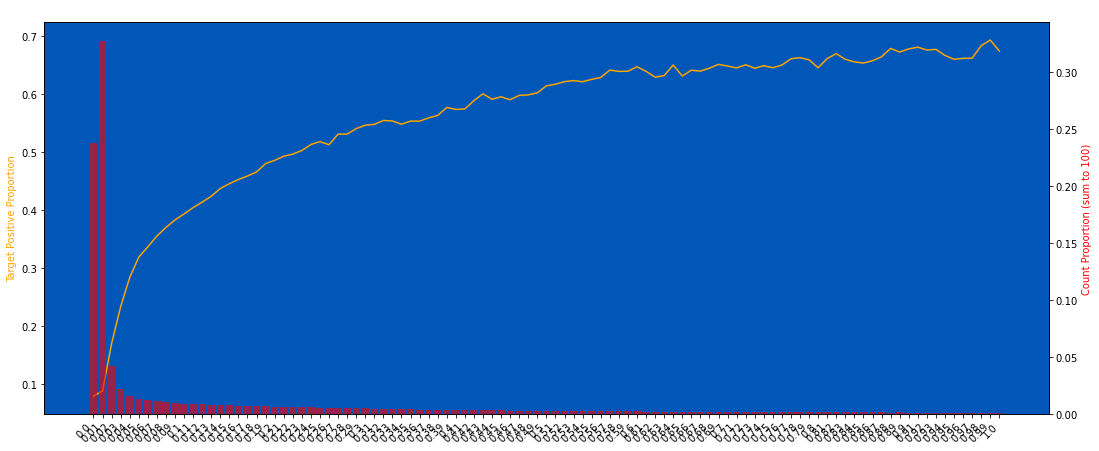

In [21]:
plot_target_check(train, "B_3", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


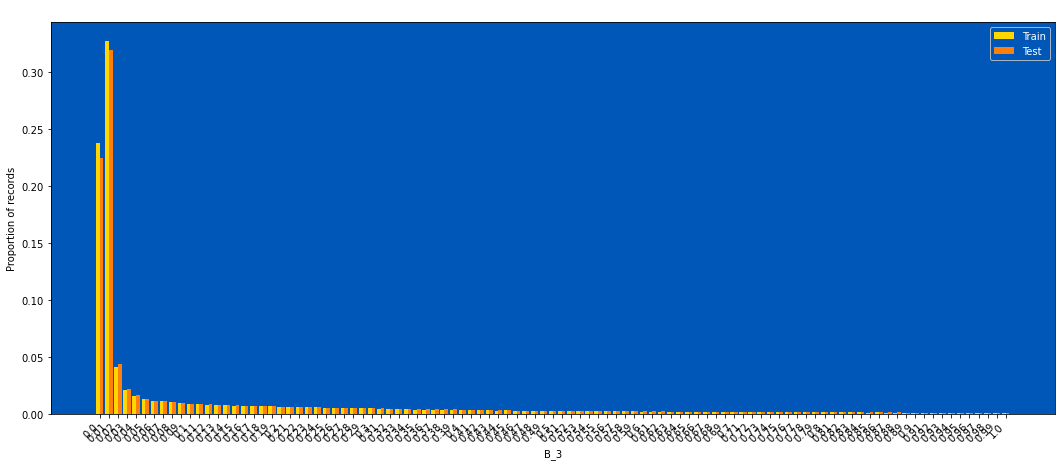

In [22]:
plot_train_test_distribution(train, test, "B_3", nunique_thr=8000)

### B_4

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


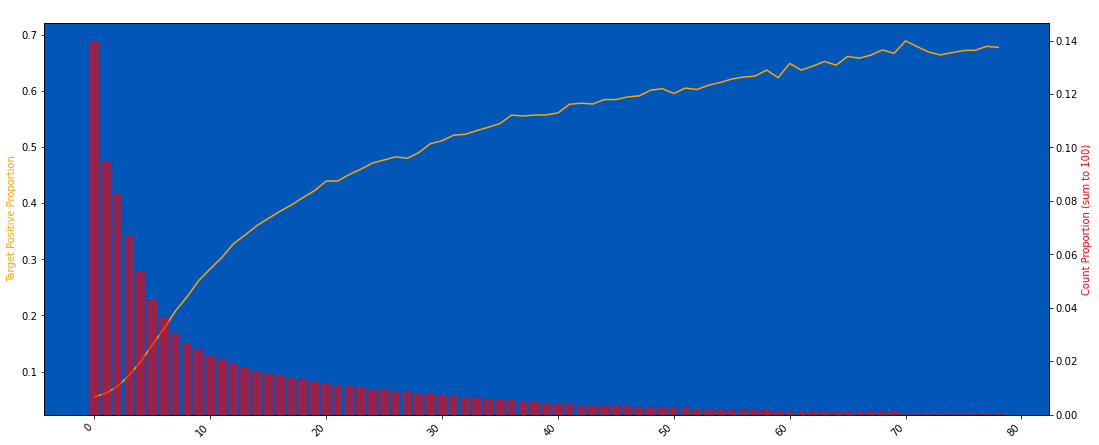

In [23]:
plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=1000)

Bottom 1% and Top 1% are dropped from this chart


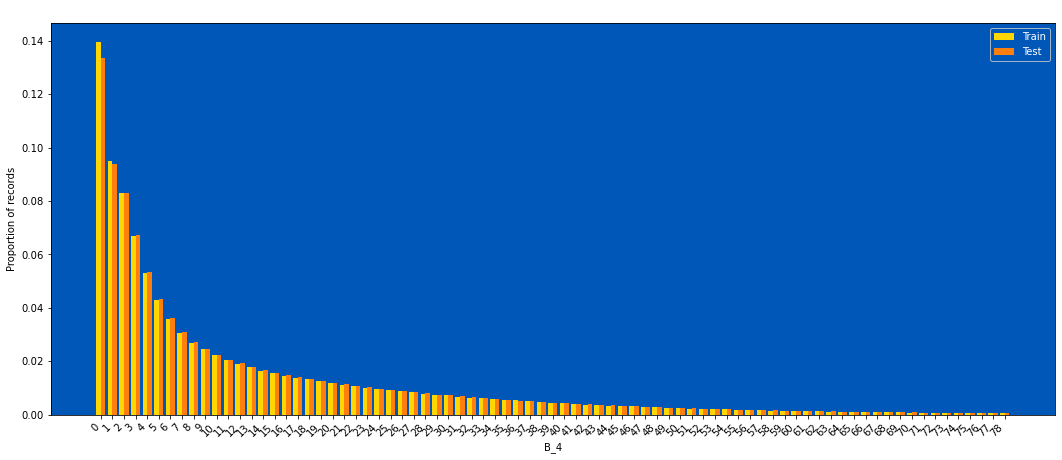

In [24]:
plot_train_test_distribution(train, test, "B_4", nunique_thr=8000)

### B_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


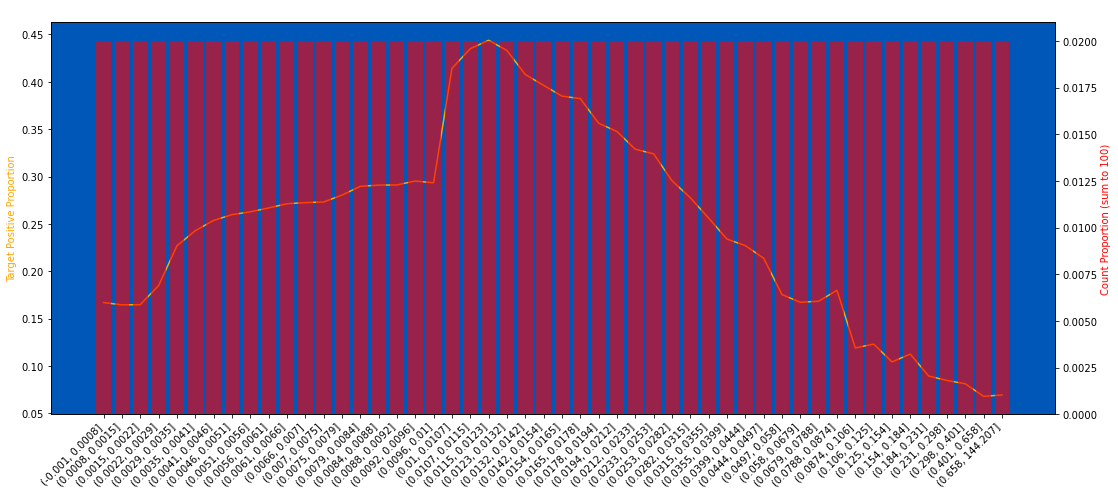

In [25]:
plot_target_check(train, "B_5", q=50, use_raw_bin=True)

In [26]:
train.loc[train["B_5"].between(0, 0.01), "B_5"] = np.nan
test.loc[test["B_5"].between(0, 0.01), "B_5"] = np.nan

In [27]:
train["B_5"] = train["B_5"].round(2)
test["B_5"] = test["B_5"].round(2)

2108895 null count, 0.381 null proportion
0.2503 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


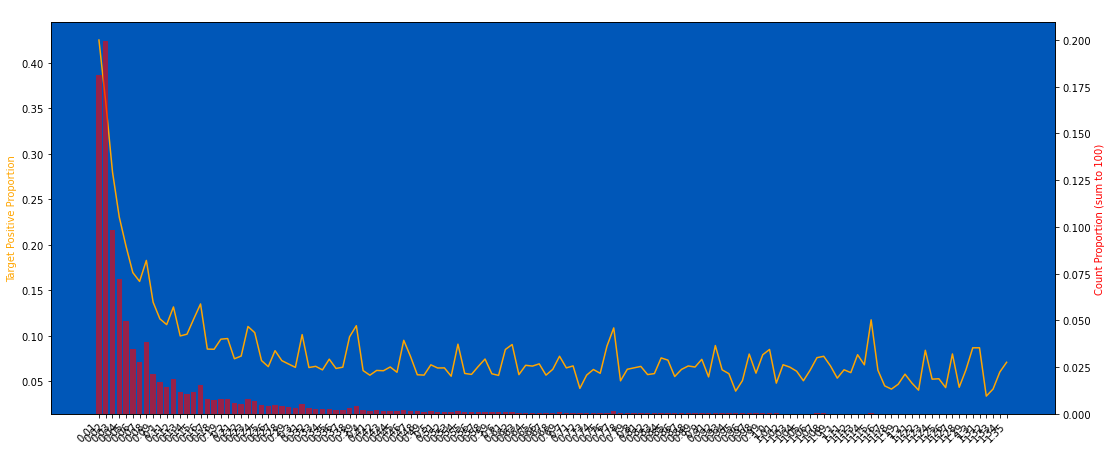

In [28]:
plot_target_check(train, "B_5", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


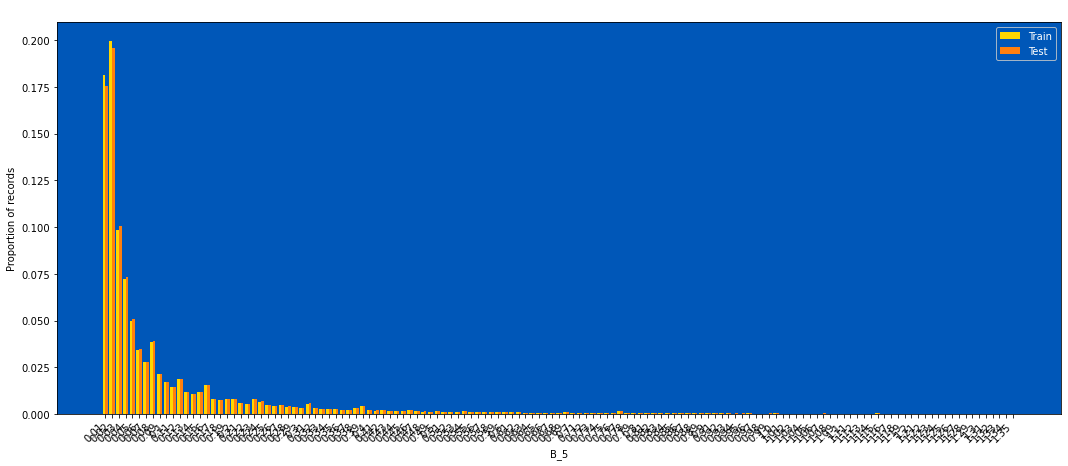

In [29]:
plot_train_test_distribution(train, test, "B_5", nunique_thr=8000)

### B_6

233 null count, 0.000 null proportion
0.2532 of the targets have label = 1


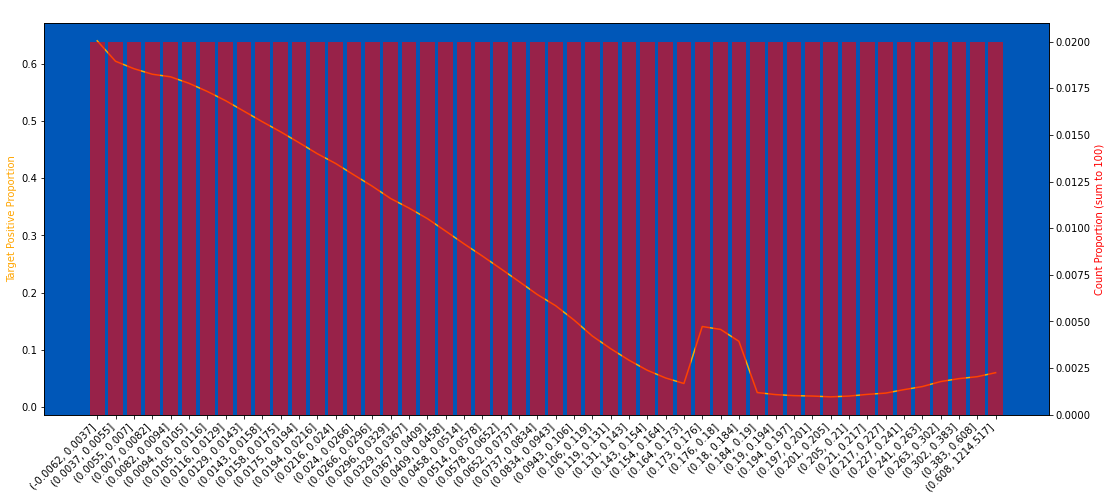

In [30]:
plot_target_check(train, "B_6", q=50, use_raw_bin=True)

In [31]:
train["B_6"] = train["B_6"].round(2)
test["B_6"] = test["B_6"].round(2)

233 null count, 0.000 null proportion
0.2532 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


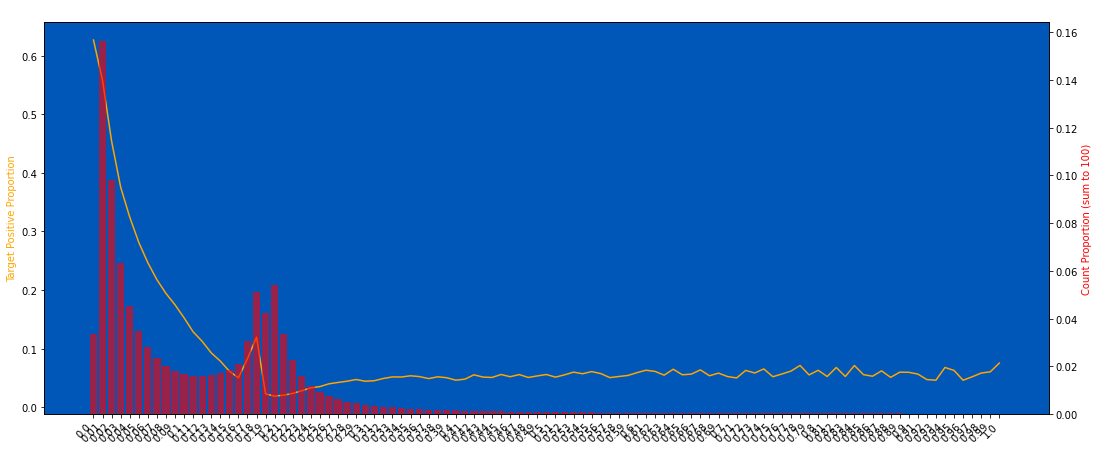

In [32]:
plot_target_check(train, "B_6", q=50, use_raw_bin=True, nunique_thr=7200, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


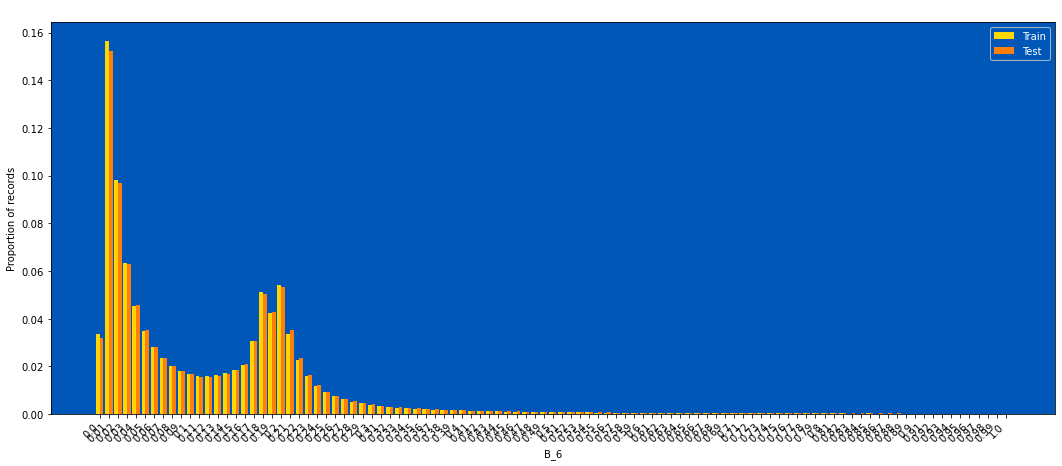

In [33]:
plot_train_test_distribution(train, test, "B_6", nunique_thr=8000)

### B_7

0 null count, 0.000 null proportion
nan of the targets have label = 1


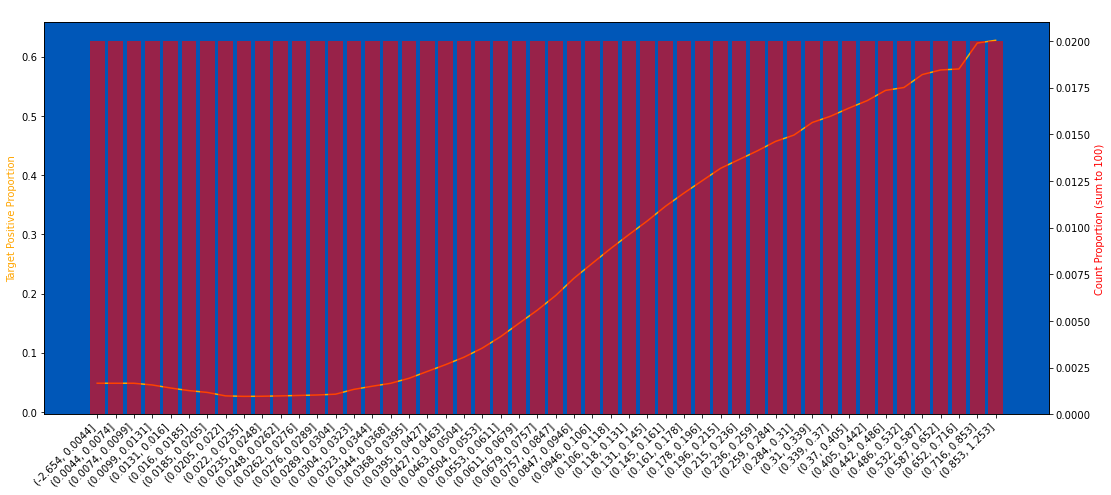

In [34]:
plot_target_check(train, "B_7", q=50, use_raw_bin=True)

In [35]:
train["B_7"] = train["B_7"].round(2)
test["B_7"] = test["B_7"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


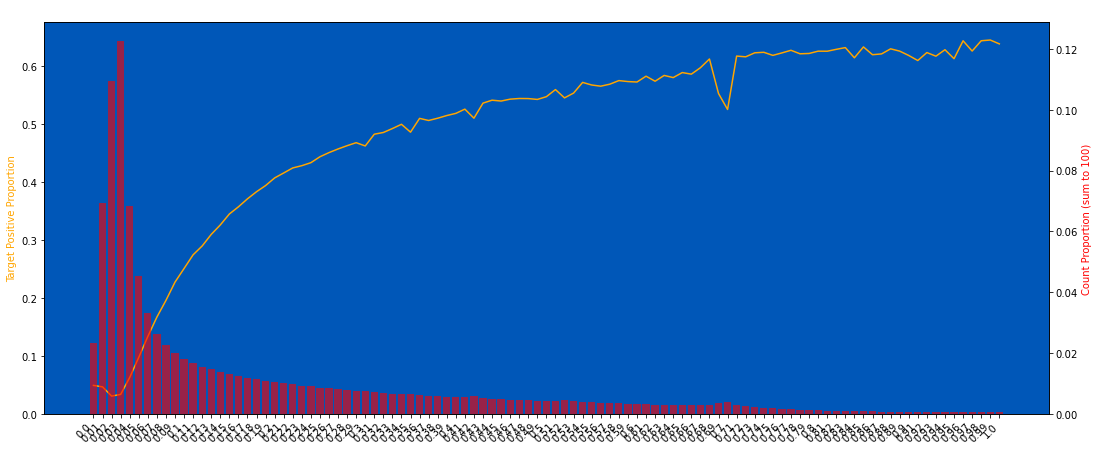

In [36]:
plot_target_check(train, "B_7", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


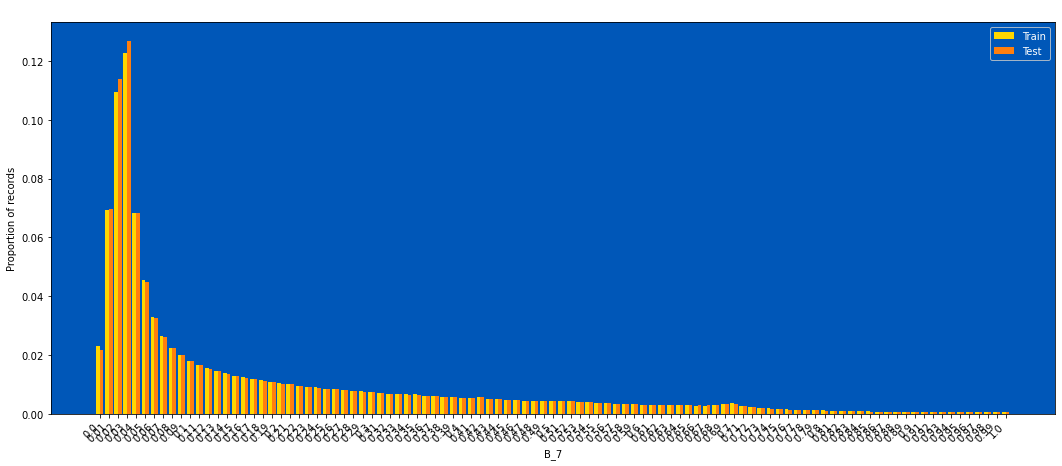

In [37]:
plot_train_test_distribution(train, test, "B_7", nunique_thr=8000)

### B_8

22268 null count, 0.004 null proportion
0.3044 of the targets have label = 1


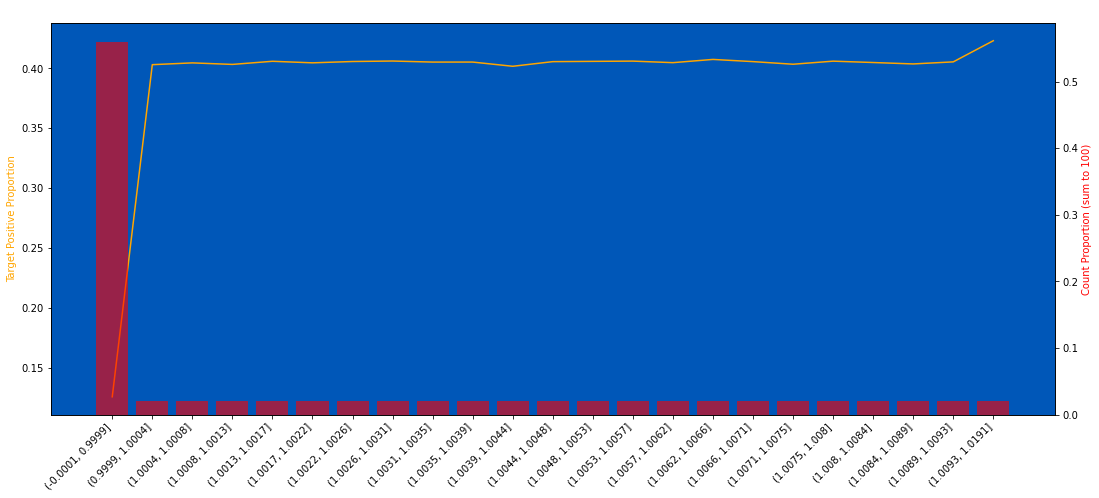

In [38]:
plot_target_check(train, "B_8", q=50, use_raw_bin=True)

In [39]:
train["B_8"] = train["B_8"].round(1)
test["B_8"] = test["B_8"].round(1)

In [40]:
train.groupby(["B_8"])["target"].mean()

B_8
0.0000   0.1233
1.0000   0.4050
Name: target, dtype: float64

22268 null count, 0.004 null proportion
0.3044 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


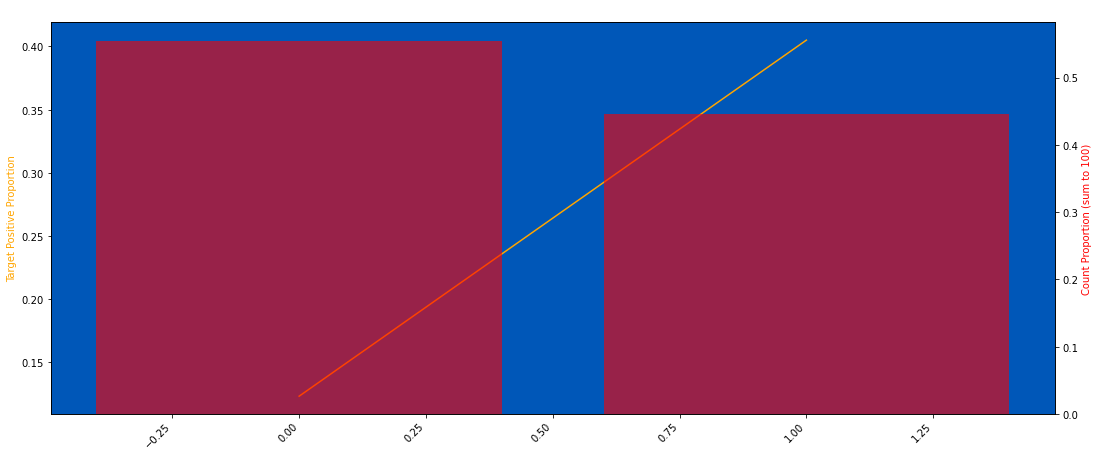

In [41]:
plot_target_check(train, "B_8", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


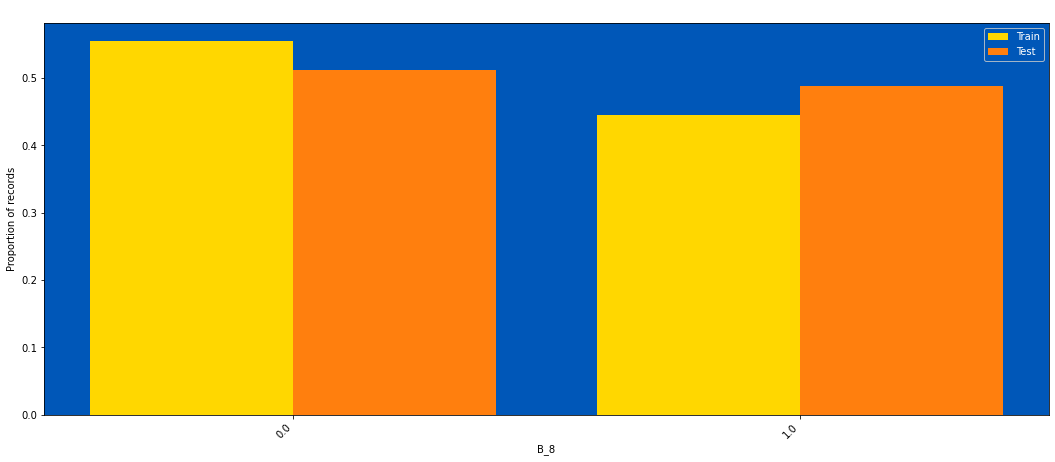

In [42]:
plot_train_test_distribution(train, test, "B_8", nunique_thr=8000)

### B_9

0 null count, 0.000 null proportion
nan of the targets have label = 1


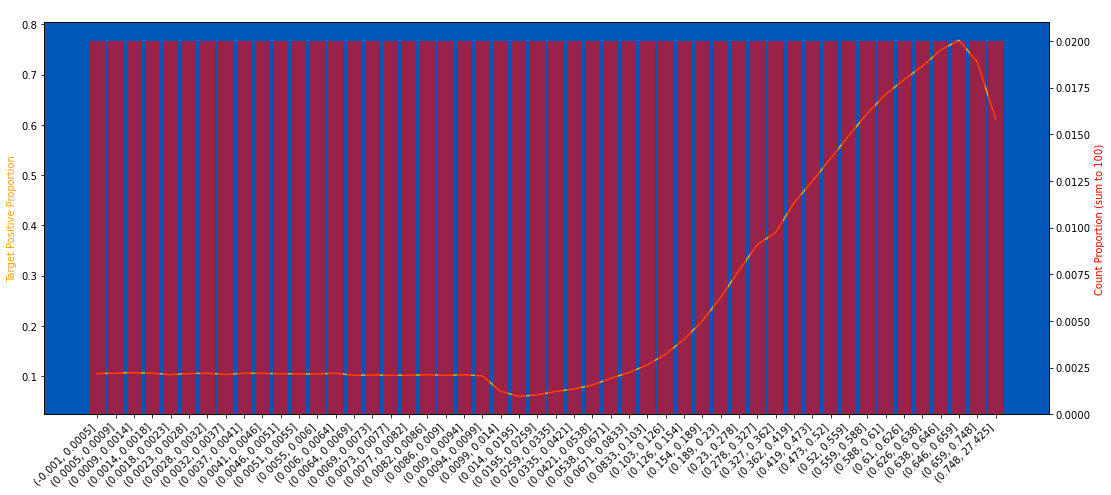

In [43]:
plot_target_check(train, "B_9", q=50, use_raw_bin=True)

In [44]:
train["B_9"] = train["B_9"].round(2)
test["B_9"] = test["B_9"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


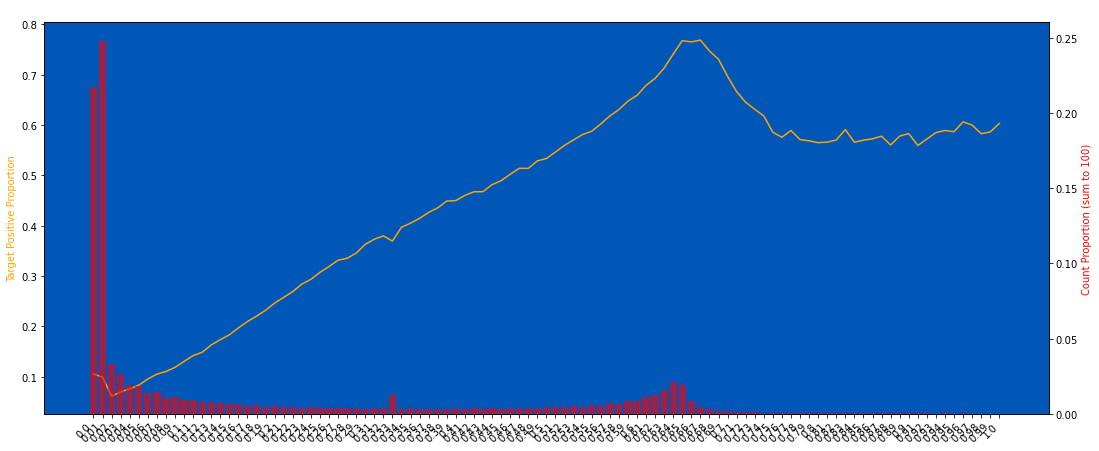

In [45]:
plot_target_check(train, "B_9", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


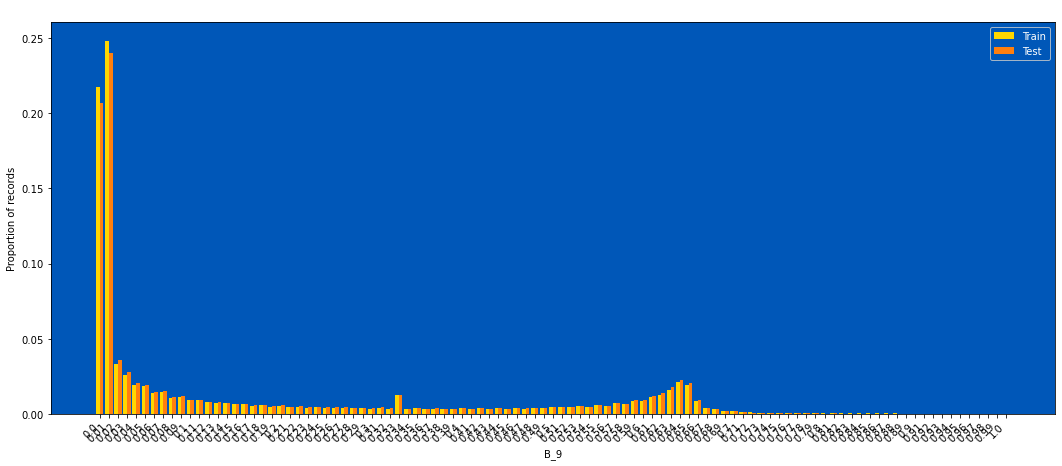

In [46]:
plot_train_test_distribution(train, test, "B_9", nunique_thr=8000)

### B_10

0 null count, 0.000 null proportion
nan of the targets have label = 1


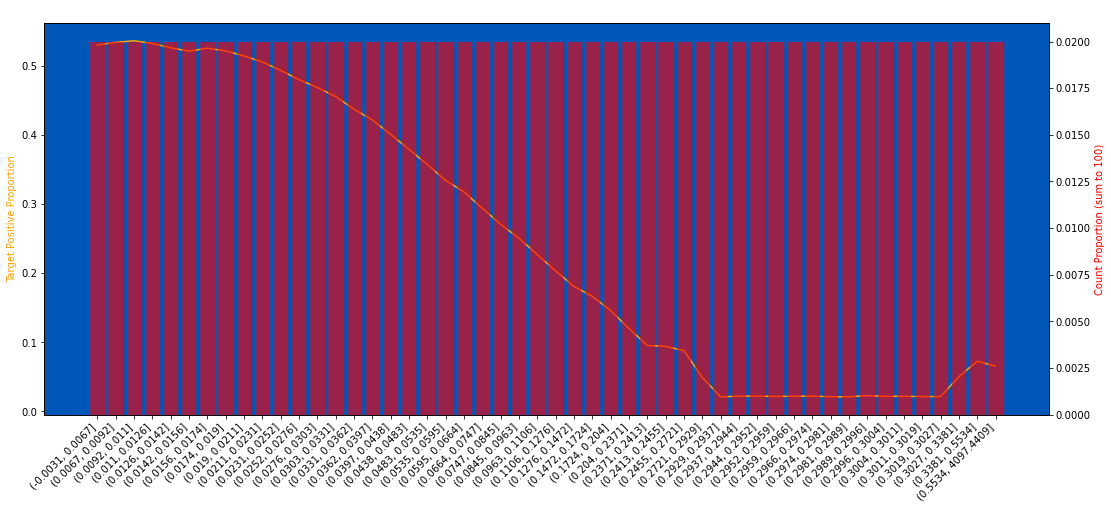

In [47]:
plot_target_check(train, "B_10", q=50, use_raw_bin=True)

In [48]:
train["B_10"] = train["B_10"].round(2)
test["B_10"] = test["B_10"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


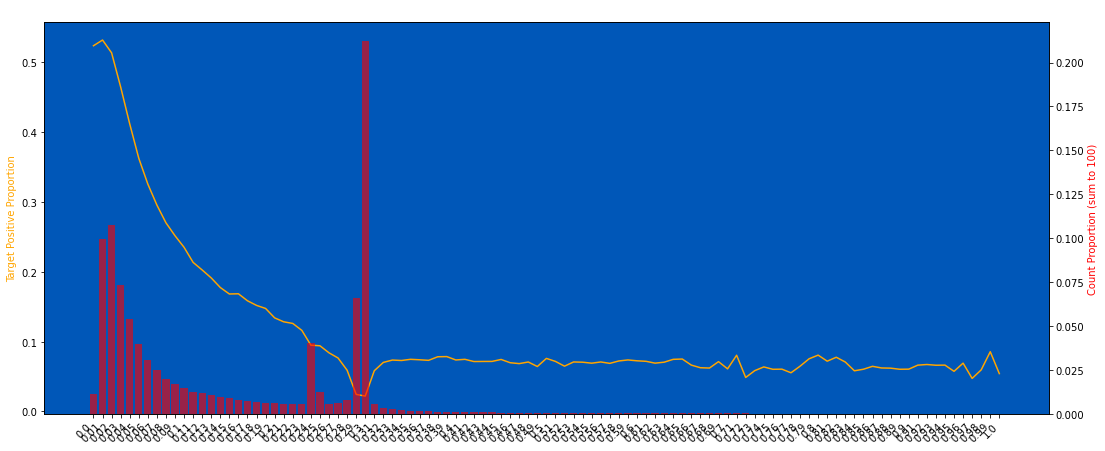

In [49]:
b10_summary = plot_target_check(train, "B_10", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


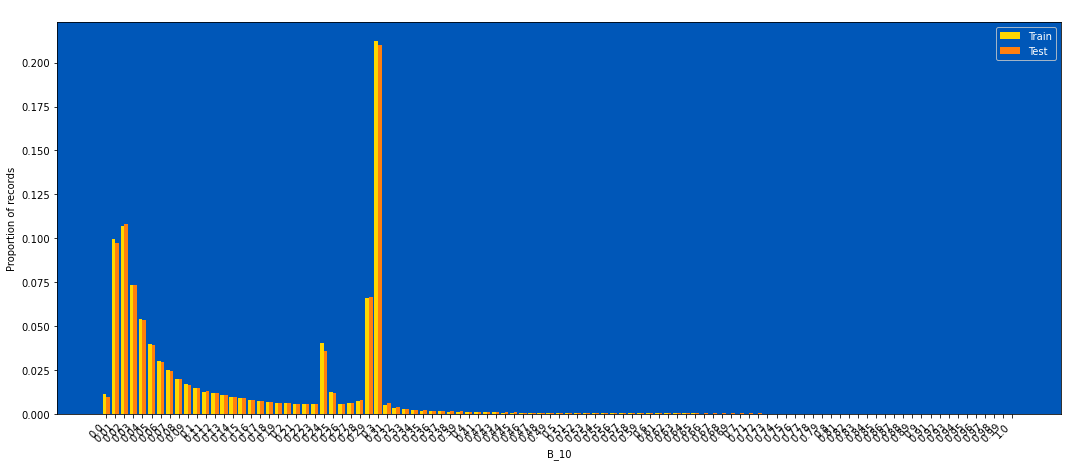

In [50]:
plot_train_test_distribution(train, test, "B_10", nunique_thr=8000)

### B_11

0 null count, 0.000 null proportion
nan of the targets have label = 1


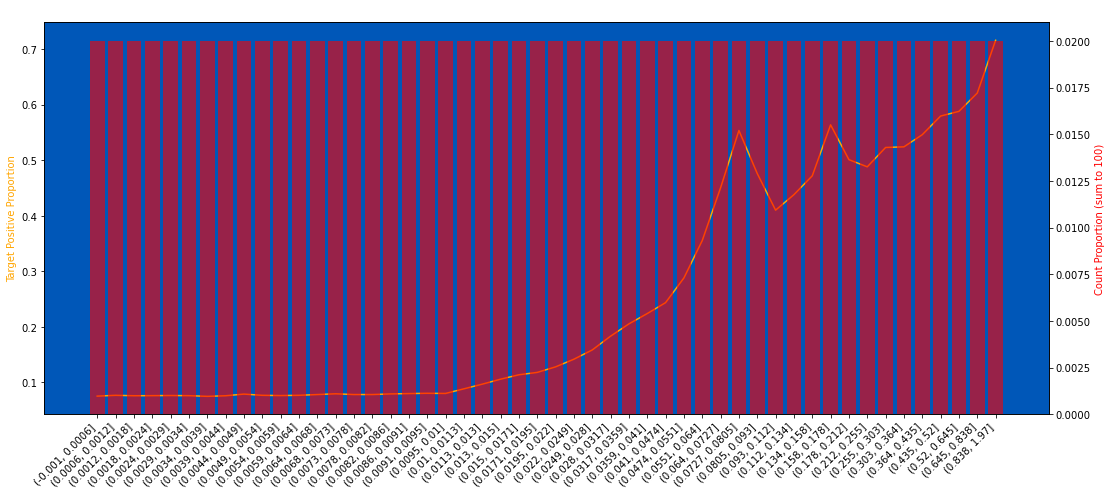

In [51]:
plot_target_check(train, "B_11", q=50, use_raw_bin=True)

In [52]:
train["B_11"] = train["B_11"].round(2)
test["B_11"] = test["B_11"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


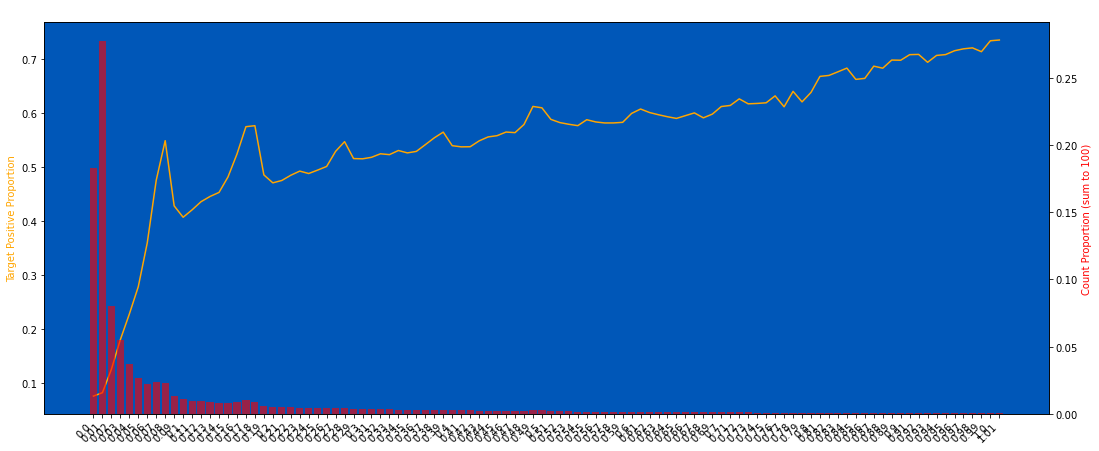

In [53]:
plot_target_check(train, "B_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


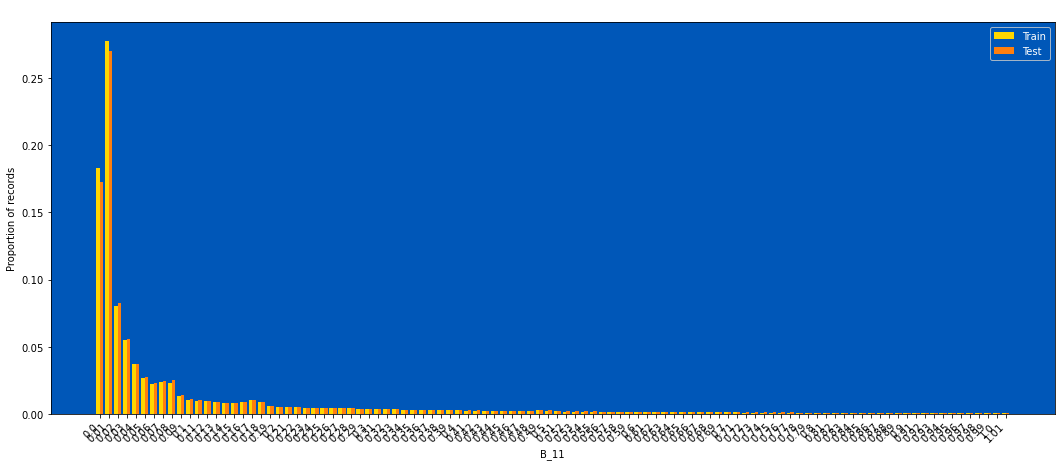

In [54]:
plot_train_test_distribution(train, test, "B_11", nunique_thr=8000)

### B_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


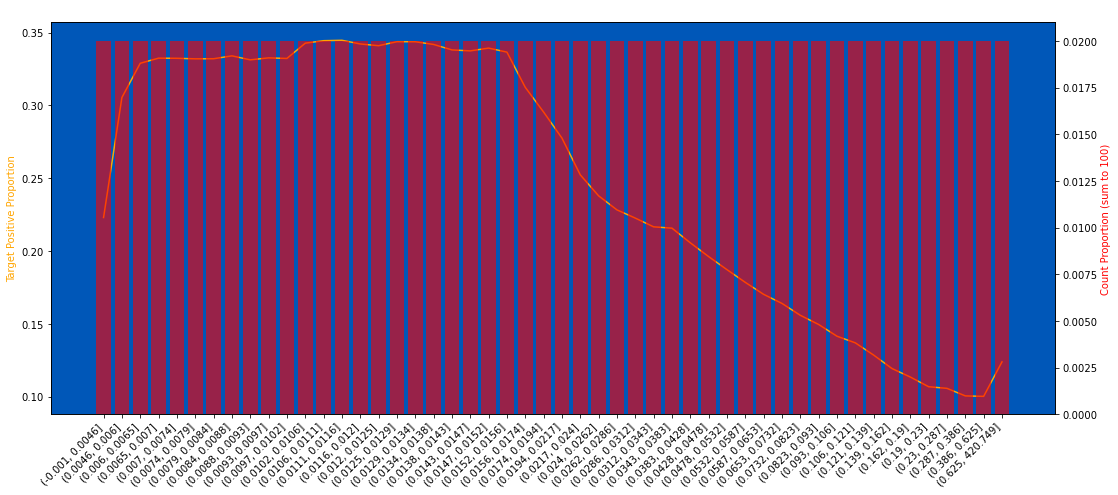

In [55]:
plot_target_check(train, "B_12", q=50, use_raw_bin=True)

In [56]:
train["B_12"] = train["B_12"].round(2)
test["B_12"] = test["B_12"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


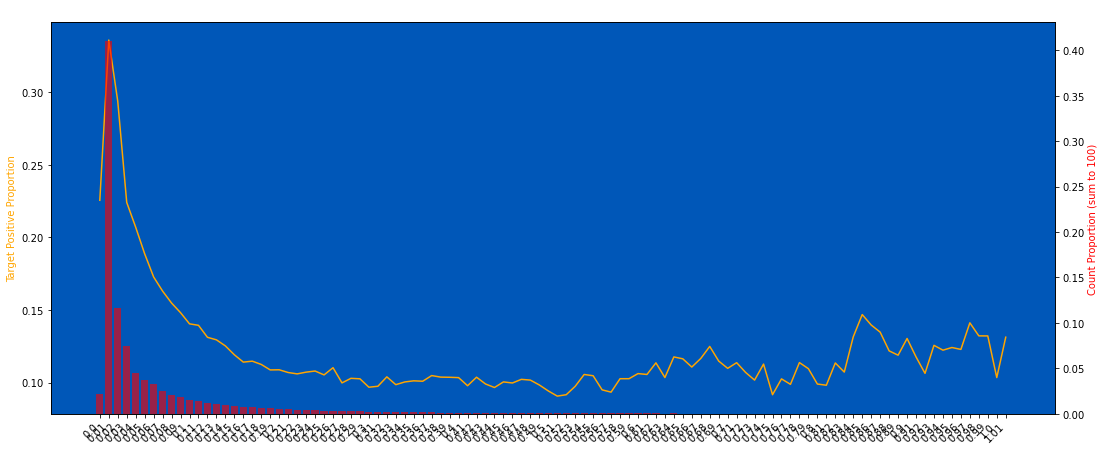

In [57]:
plot_target_check(train, "B_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [58]:
train.loc[train["B_12"] == 0, "B_12"] = np.nan
test.loc[test["B_12"] == 0, "B_12"] = np.nan

122422 null count, 0.022 null proportion
0.2256 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


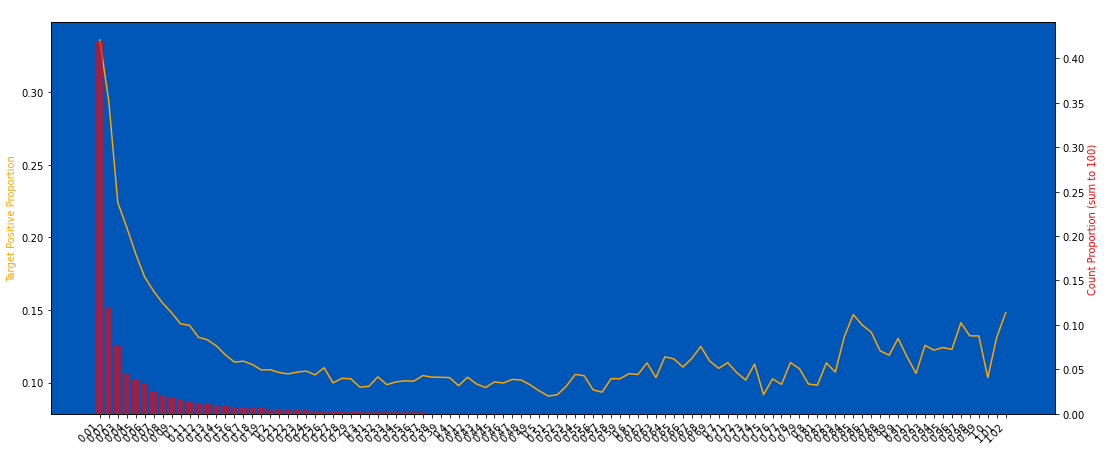

In [59]:
plot_target_check(train, "B_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


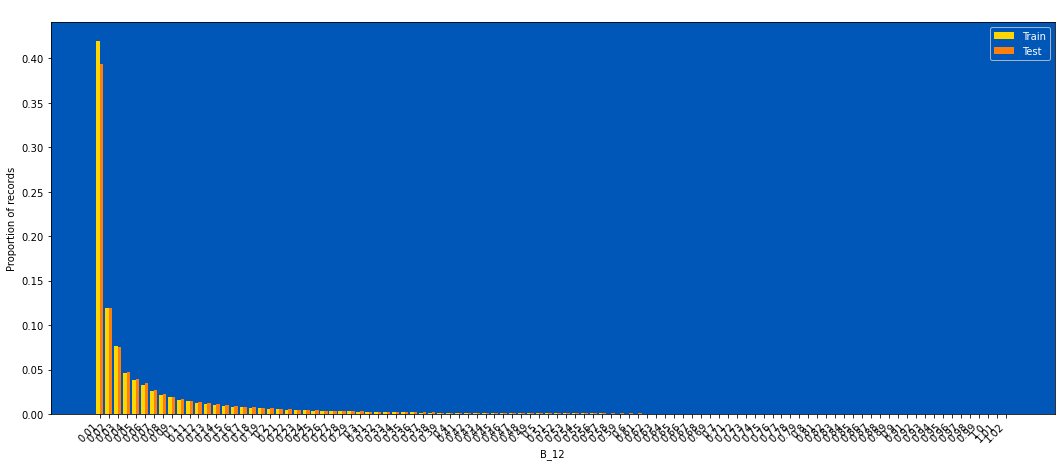

In [60]:
plot_train_test_distribution(train, test, "B_12", nunique_thr=8000)

### B_13

49519 null count, 0.009 null proportion
0.4906 of the targets have label = 1


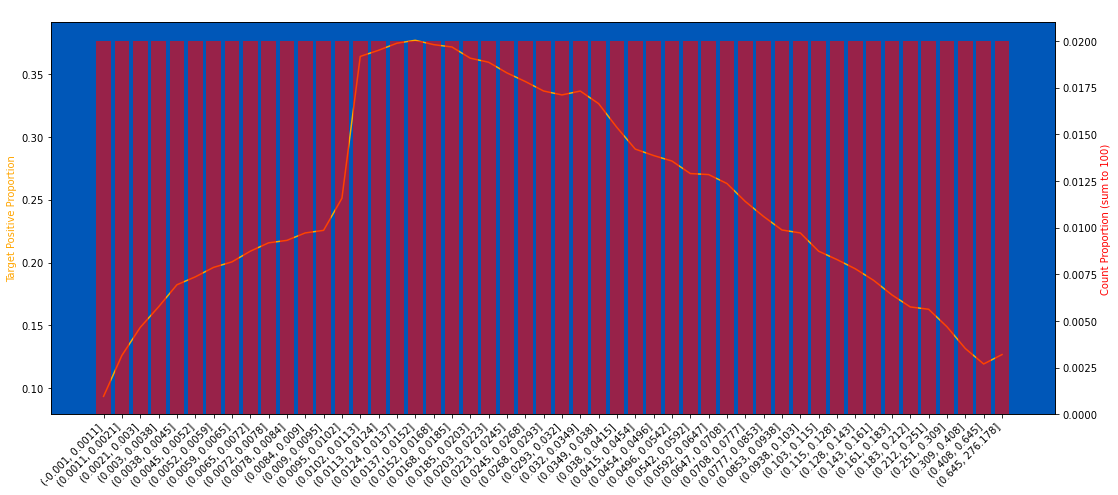

In [61]:
plot_target_check(train, "B_13", q=50, use_raw_bin=True)

In [62]:
train.loc[train["B_13"].between(0, 0.01), "B_13"] = np.nan
test.loc[test["B_13"].between(0, 0.01), "B_13"] = np.nan

In [63]:
train["B_13"] = train["B_13"].round(2)
test["B_13"] = test["B_13"].round(2)

1565474 null count, 0.283 null proportion
0.1962 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


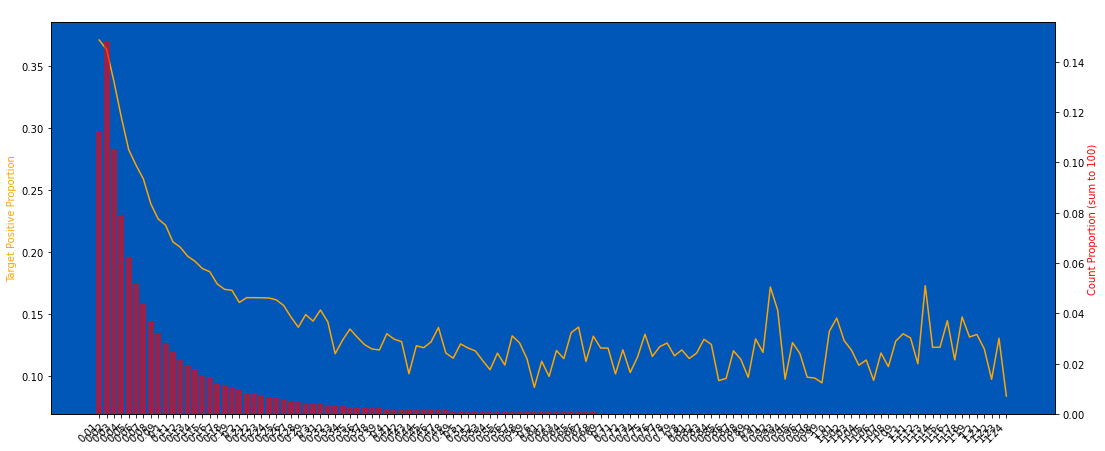

In [64]:
plot_target_check(train, "B_13", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


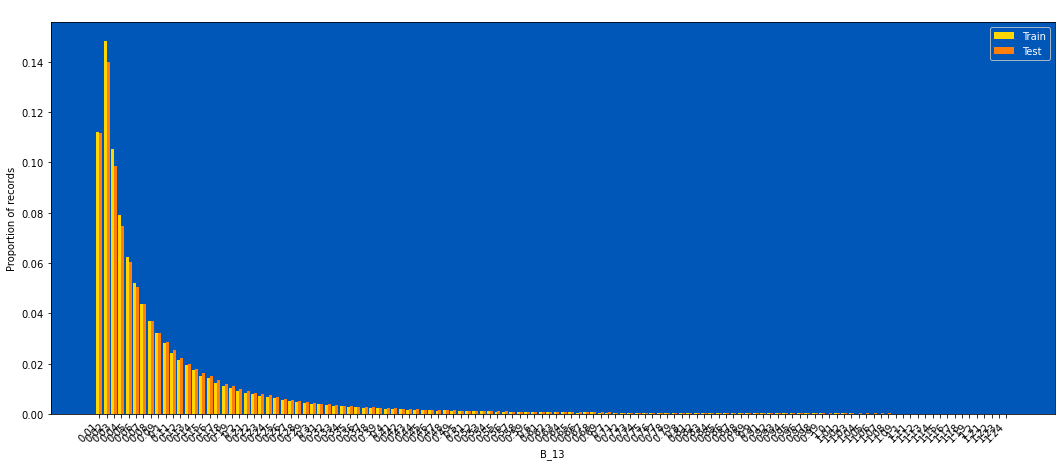

In [65]:
plot_train_test_distribution(train, test, "B_13", nunique_thr=8000)

### B_14

0 null count, 0.000 null proportion
nan of the targets have label = 1


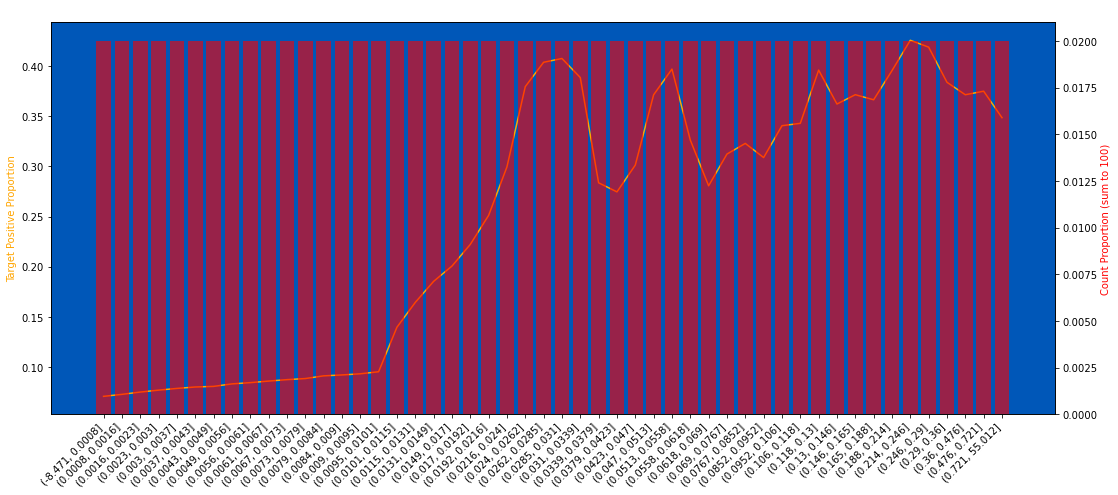

In [66]:
plot_target_check(train, "B_14", q=50, use_raw_bin=True)

In [67]:
train["B_14"] = train["B_14"].round(2)
test["B_14"] = test["B_14"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


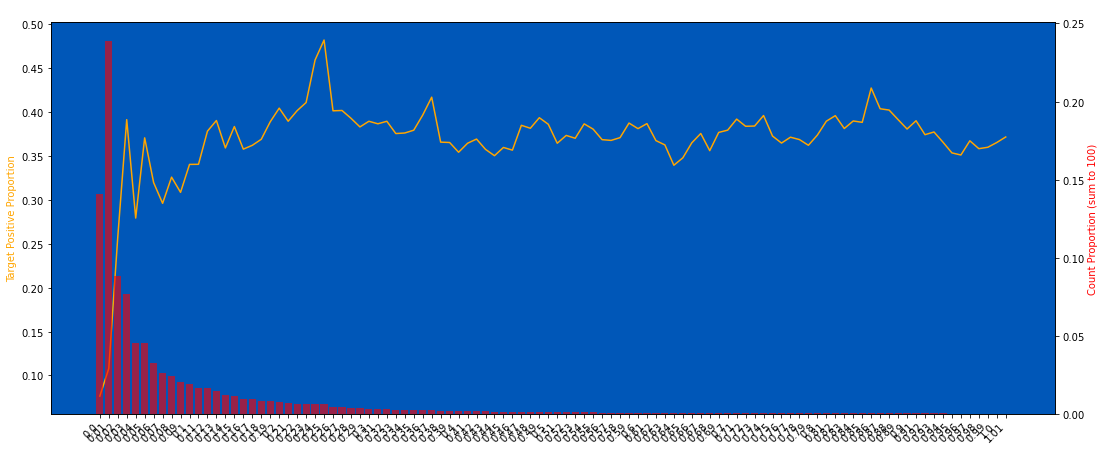

In [68]:
plot_target_check(train, "B_14", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


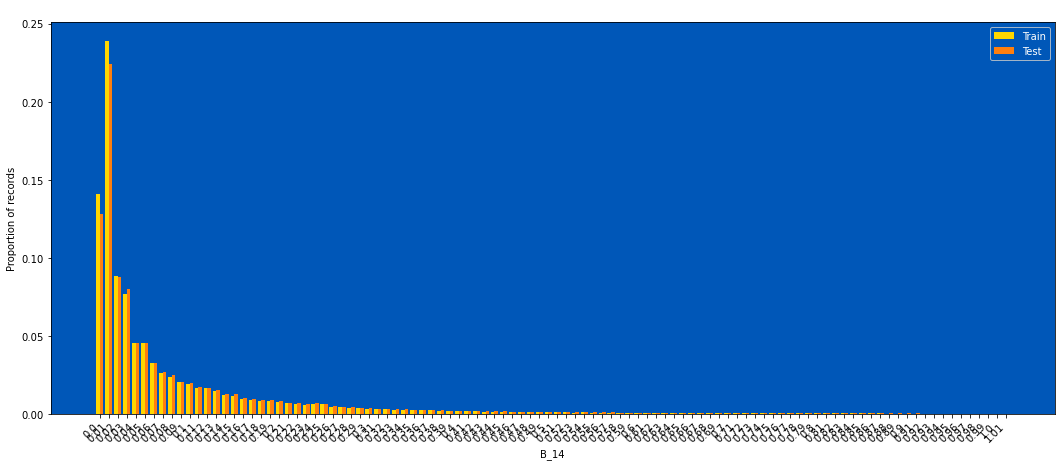

In [69]:
plot_train_test_distribution(train, test, "B_14", nunique_thr=8000)

### B_15

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1


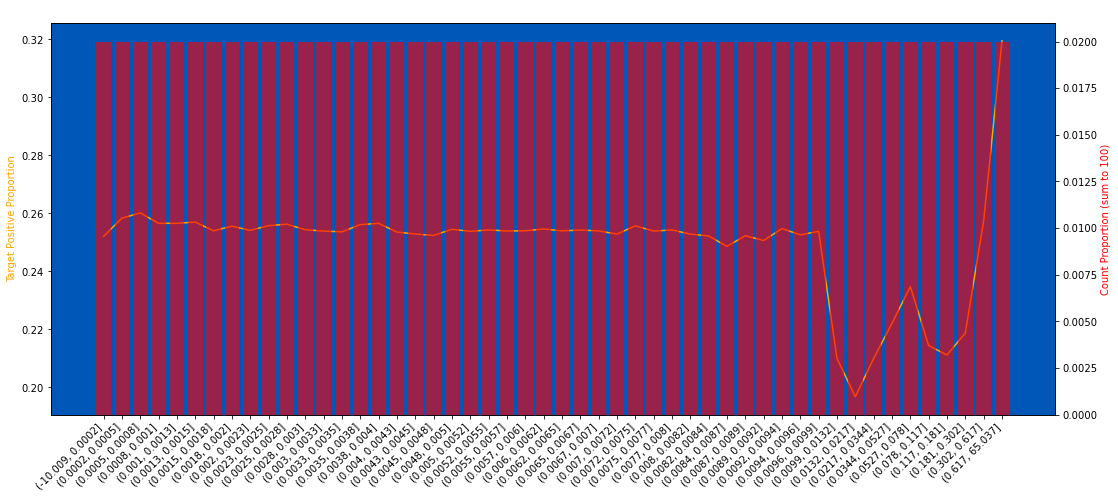

In [70]:
plot_target_check(train, "B_15", q=50, use_raw_bin=True)

In [71]:
train["B_15"] = train["B_15"].round(2)
test["B_15"] = test["B_15"].round(2)

In [72]:
train.loc[train["B_15"].between(0, 0.0101), "B_15"] = 0.01
test.loc[test["B_15"].between(0, 0.0101), "B_15"] = 0.01

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


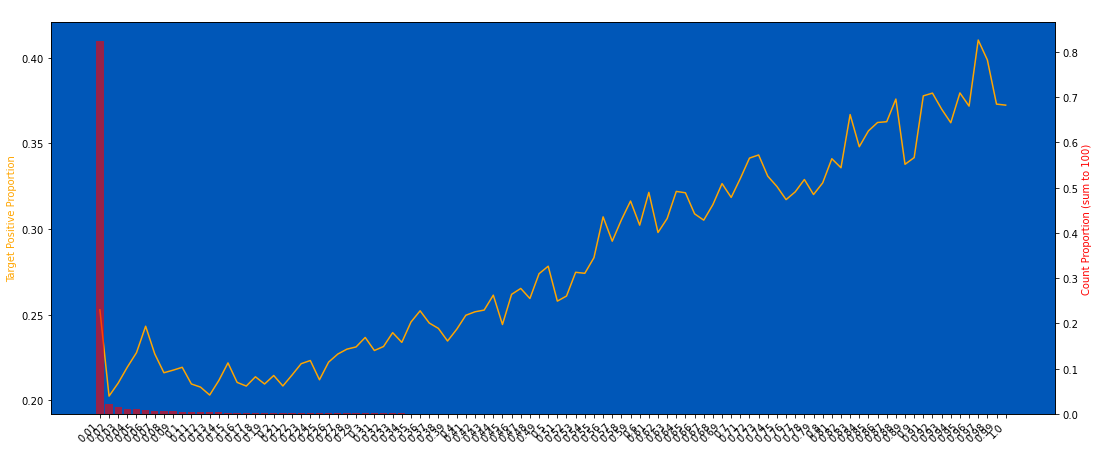

In [73]:
plot_target_check(train, "B_15", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True)

### B_16

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


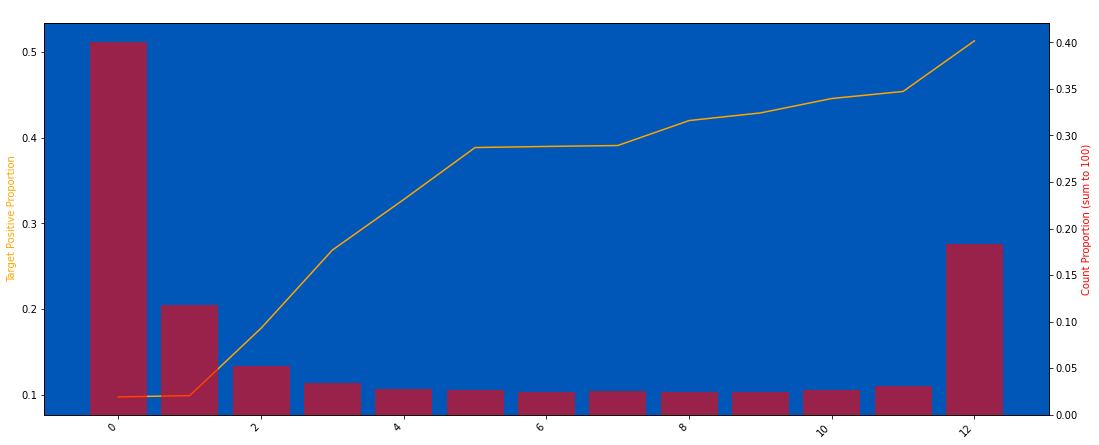

In [74]:
plot_target_check(train, "B_16", q=50, use_raw_bin=True)

### B_17

3137598 null count, 0.567 null proportion
0.1226 of the targets have label = 1


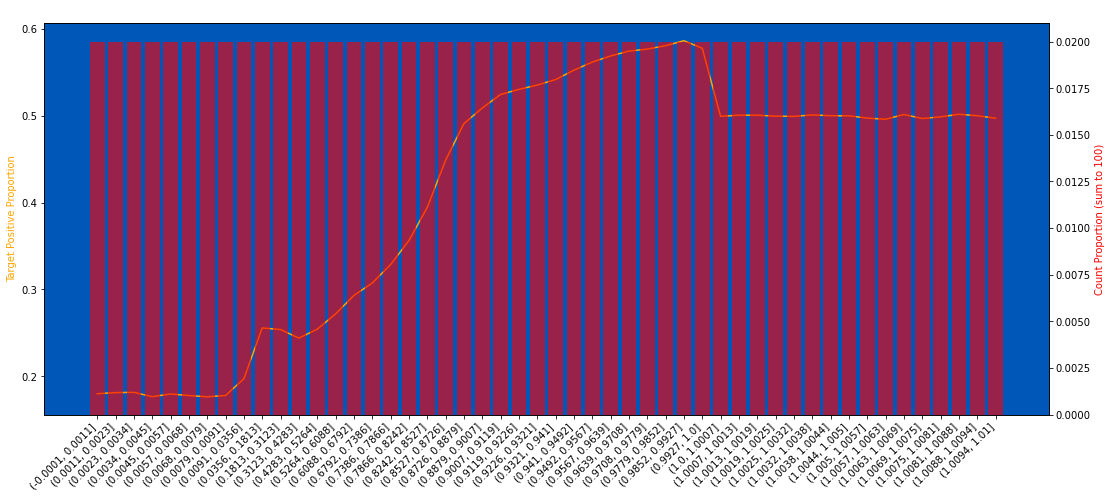

In [75]:
plot_target_check(train, "B_17", q=50, use_raw_bin=True)

In [76]:
train["B_17"] = train["B_17"].round(2)
test["B_17"] = test["B_17"].round(2)

In [77]:
train.loc[train["B_17"].between(-1, 0.01), "B_17"] = np.nan
test.loc[test["B_17"].between(-1, 0.01), "B_17"] = np.nan

In [78]:
train.loc[train["B_17"].between(1, 1.01), "B_17"] = np.nan
test.loc[test["B_17"].between(1, 1.01), "B_17"] = np.nan

4361833 null count, 0.789 null proportion
0.1979 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


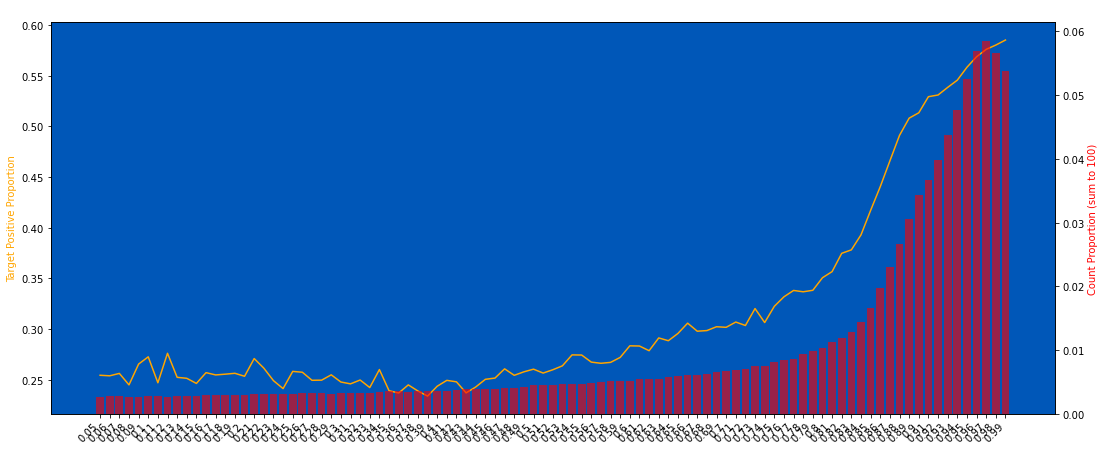

In [79]:
plot_target_check(train, "B_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### B_18

0 null count, 0.000 null proportion
nan of the targets have label = 1


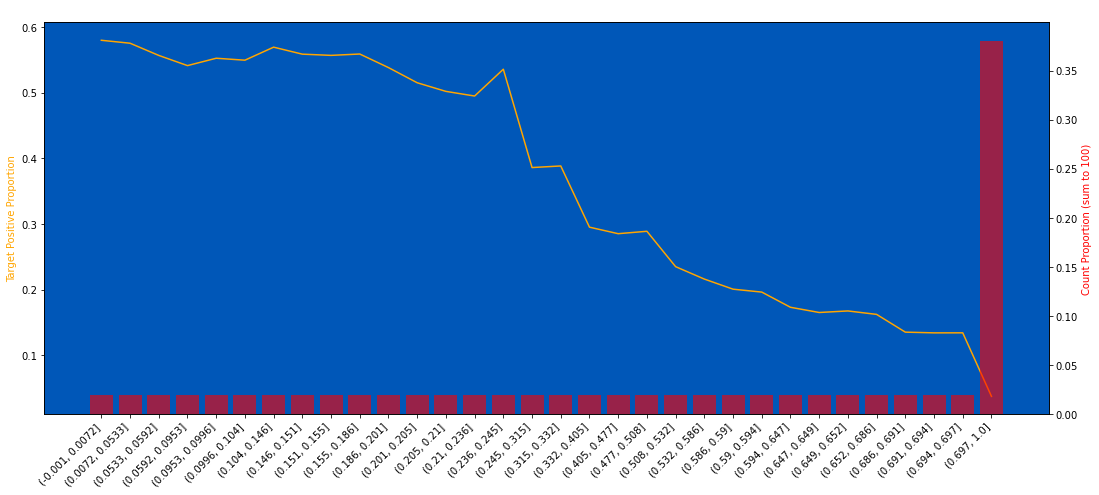

In [80]:
plot_target_check(train, "B_18", q=50, use_raw_bin=True)

In [81]:
train["B_18"] = train["B_18"].round(2)
test["B_18"] = test["B_18"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


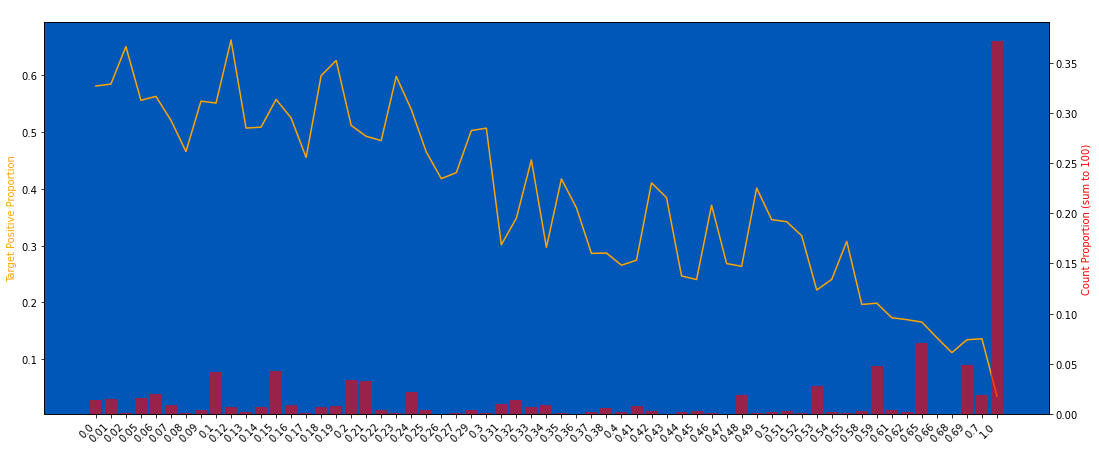

In [82]:
plot_target_check(train, "B_18", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

### B_19

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


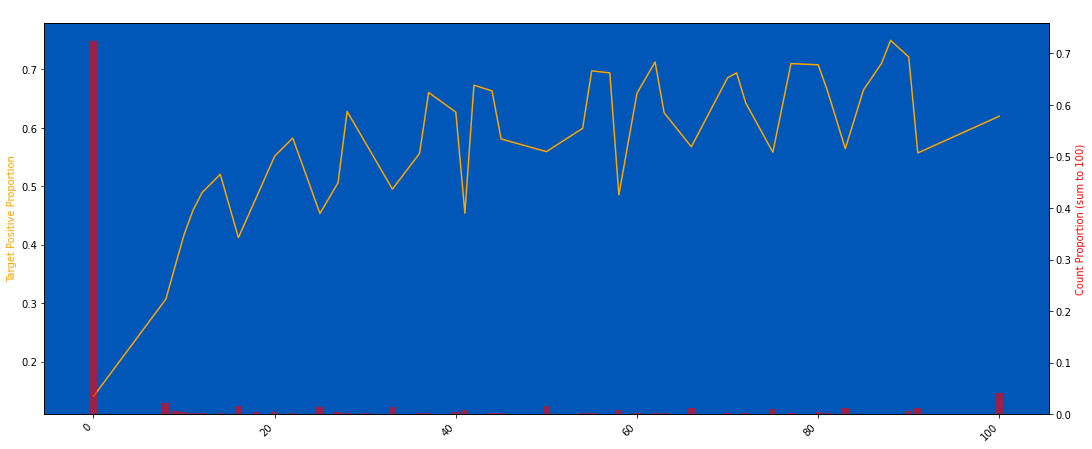

In [83]:
plot_target_check(train, "B_19", q=50, use_raw_bin=True)

### B_20

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


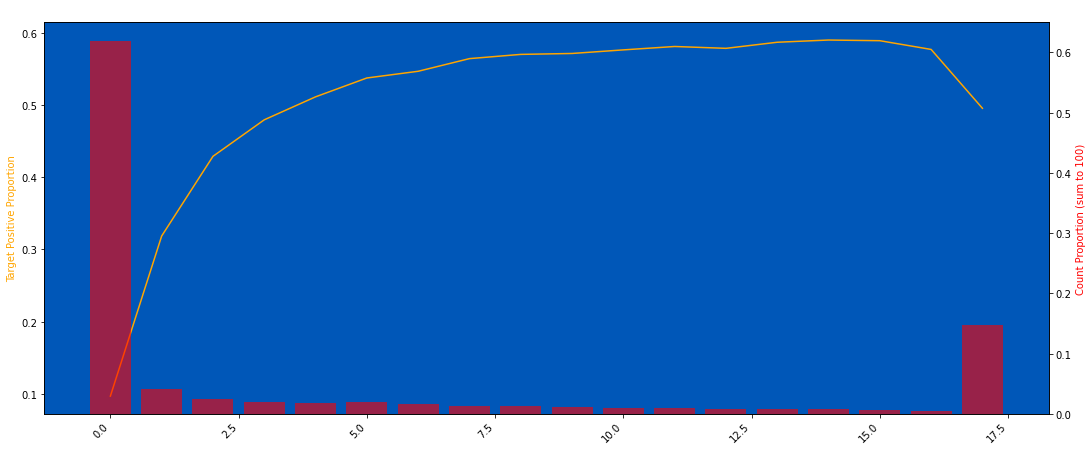

In [84]:
plot_target_check(train, "B_20", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


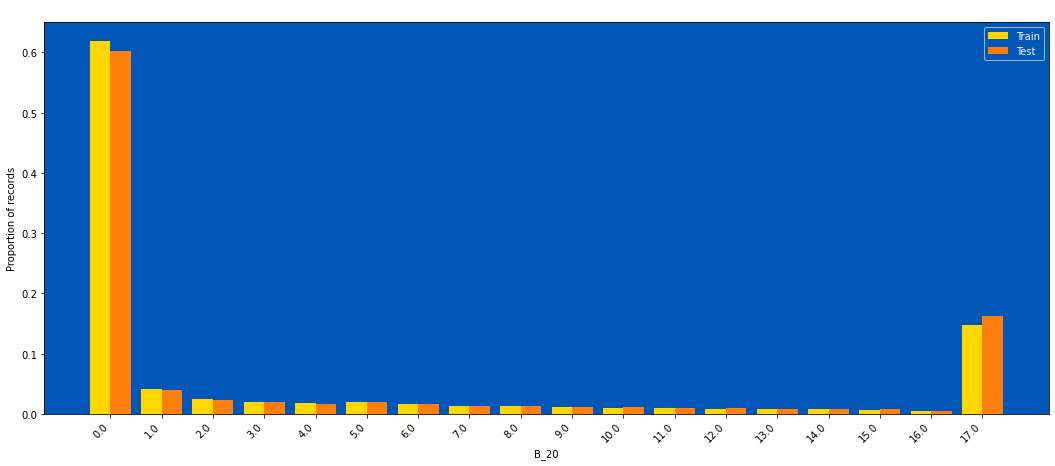

In [85]:
plot_train_test_distribution(train, test, "B_20", nunique_thr=8000)

### B_21

0 null count, 0.000 null proportion
nan of the targets have label = 1


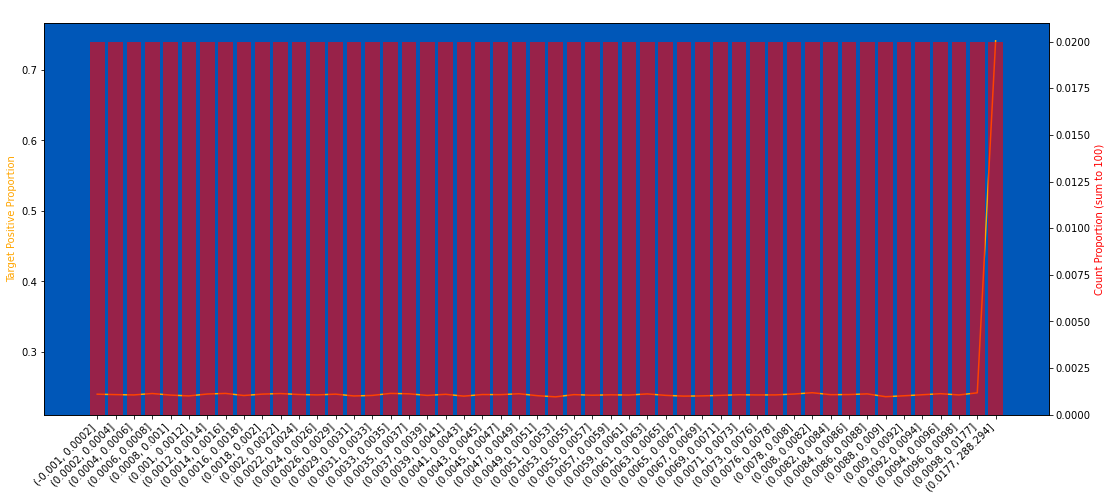

In [86]:
plot_target_check(train, "B_21", q=50, use_raw_bin=True)

In [87]:
train["B_21"] = train["B_21"].round(2)
test["B_21"] = test["B_21"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


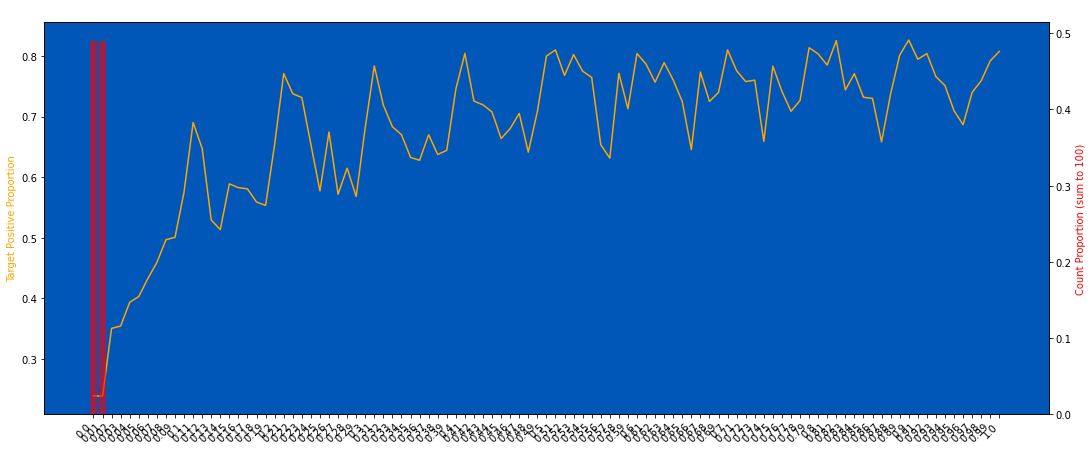

In [88]:
plot_target_check(train, "B_21", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

### B_22

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


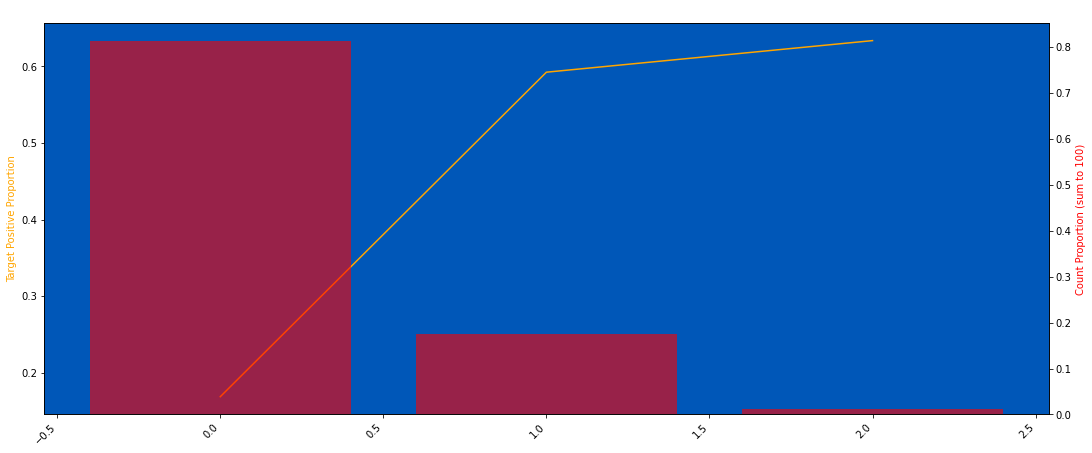

In [89]:
plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000)

### B_23

0 null count, 0.000 null proportion
nan of the targets have label = 1


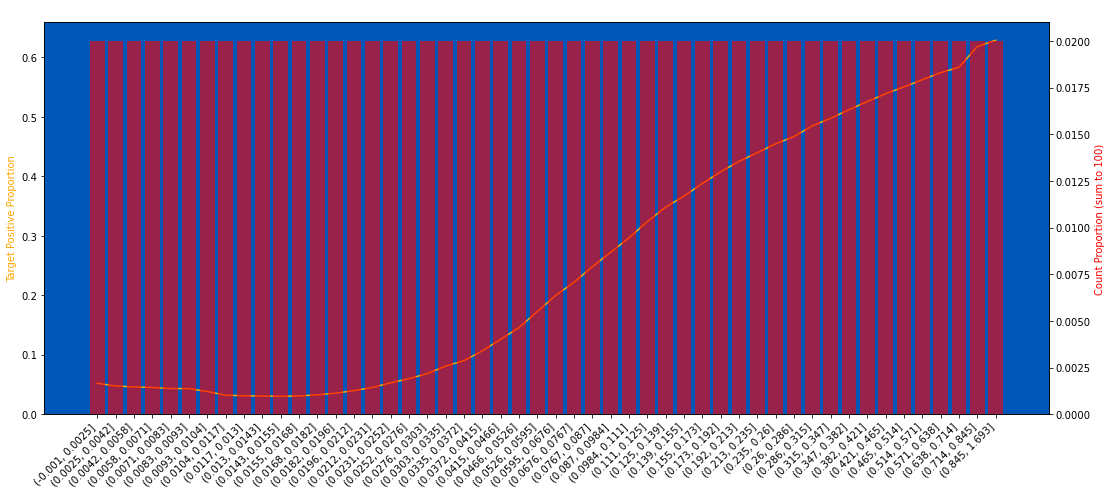

In [90]:
plot_target_check(train, "B_23", q=50, use_raw_bin=True)

In [91]:
train["B_23"] = train["B_23"].round(2)
test["B_23"] = test["B_23"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


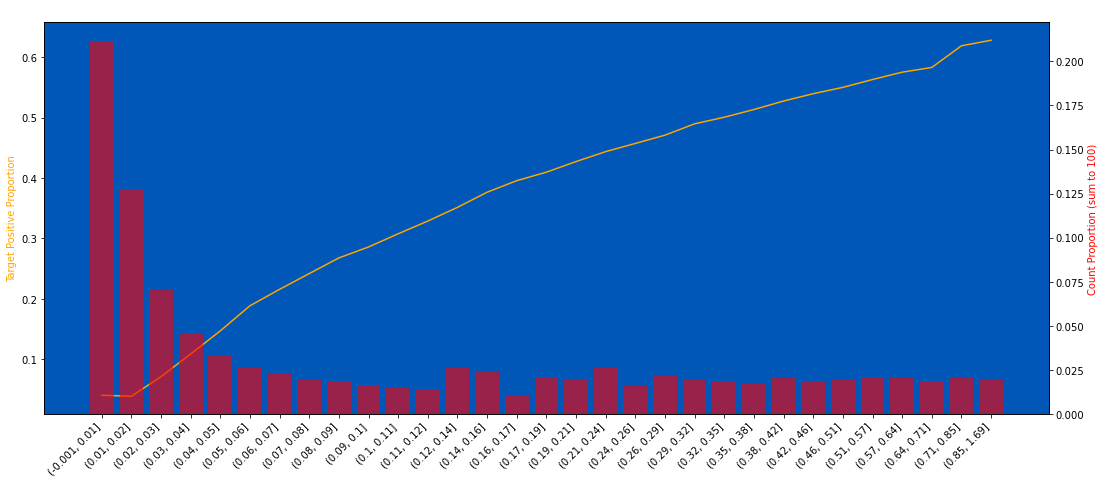

In [92]:
plot_target_check(train, "B_23", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


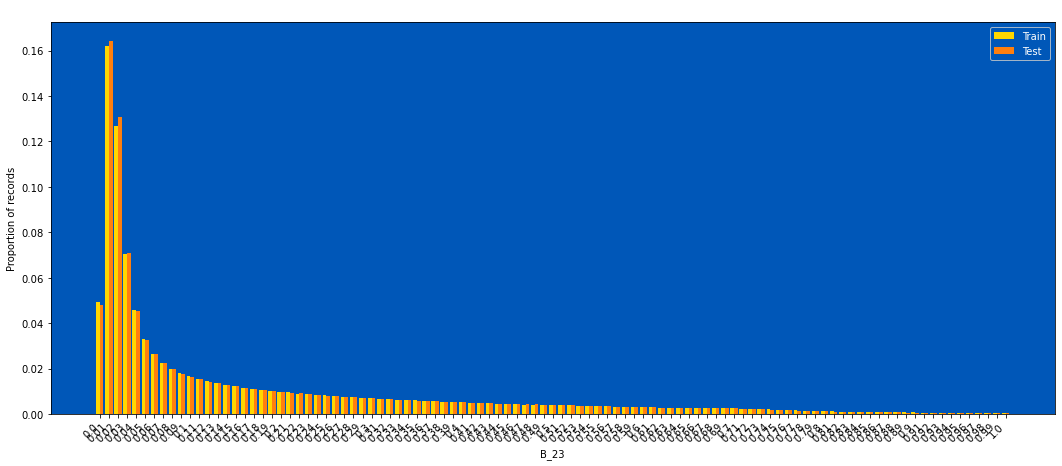

In [93]:
plot_train_test_distribution(train, test, "B_23", nunique_thr=8000)

### B_24

0 null count, 0.000 null proportion
nan of the targets have label = 1


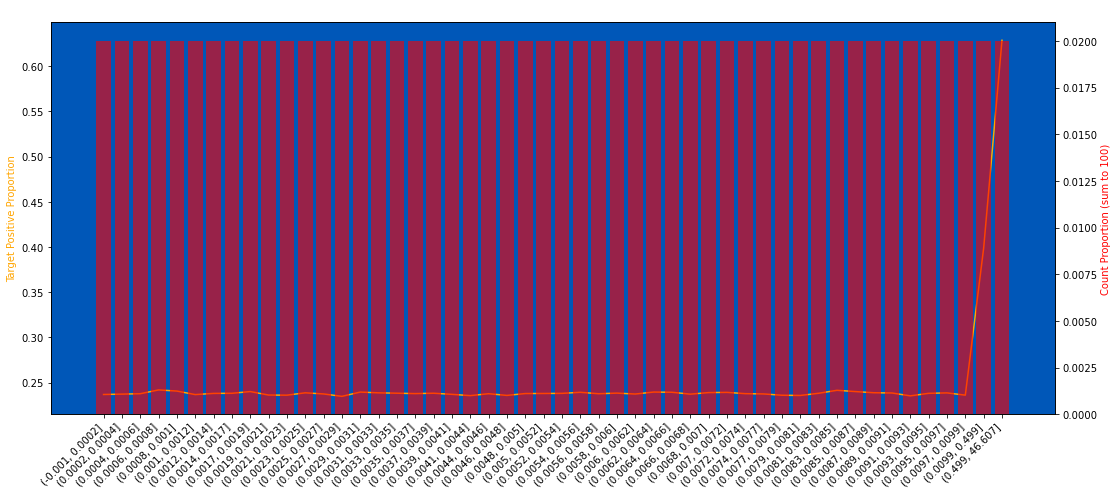

In [94]:
plot_target_check(train, "B_24", q=50, use_raw_bin=True)

In [95]:
train["B_24"] = train["B_24"].round(2)
test["B_24"] = test["B_24"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1


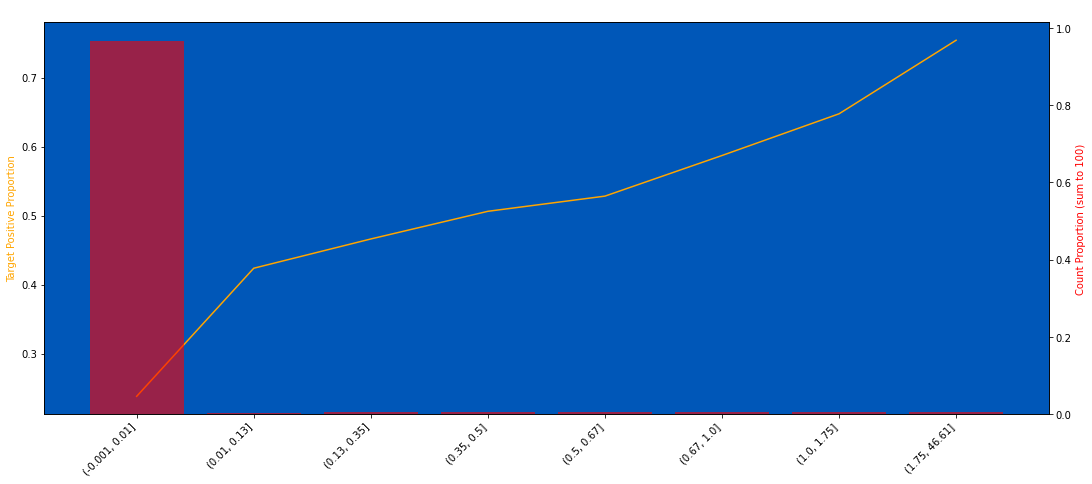

In [96]:
plot_target_check(train, "B_24", q=200, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


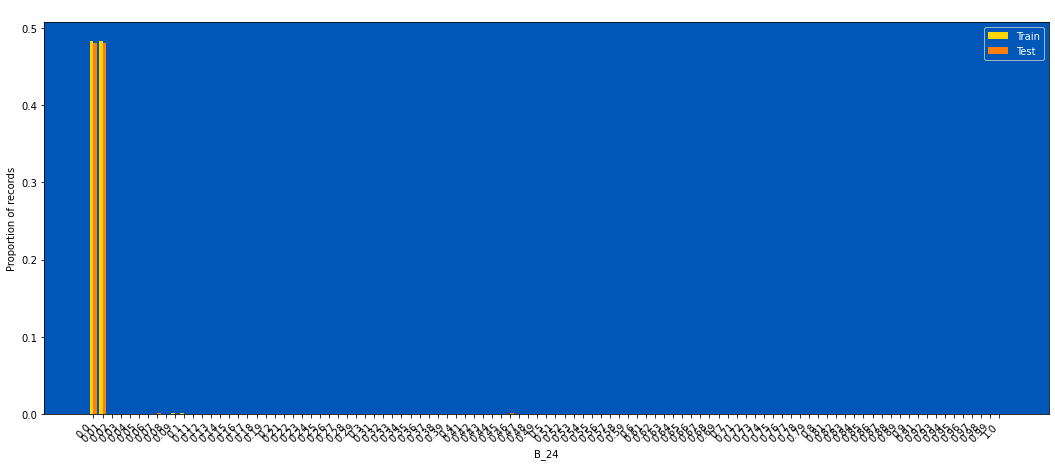

In [97]:
plot_train_test_distribution(train, test, "B_24", nunique_thr=8000)

### B_25

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1


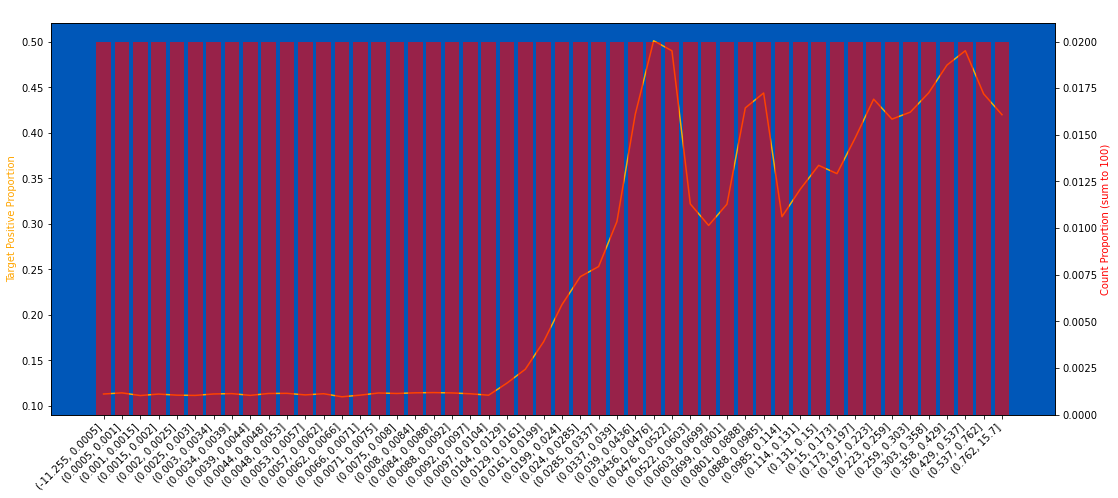

In [98]:
plot_target_check(train, "B_25", q=50, use_raw_bin=True)

In [99]:
train["B_25"] = train["B_25"].round(2)
test["B_25"] = test["B_25"].round(2)

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


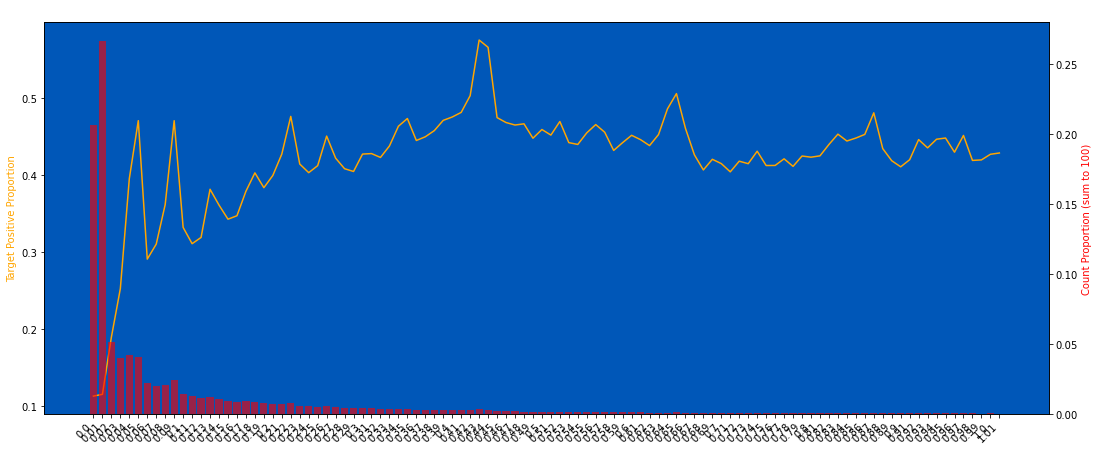

In [100]:
plot_target_check(train, "B_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### B_26

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


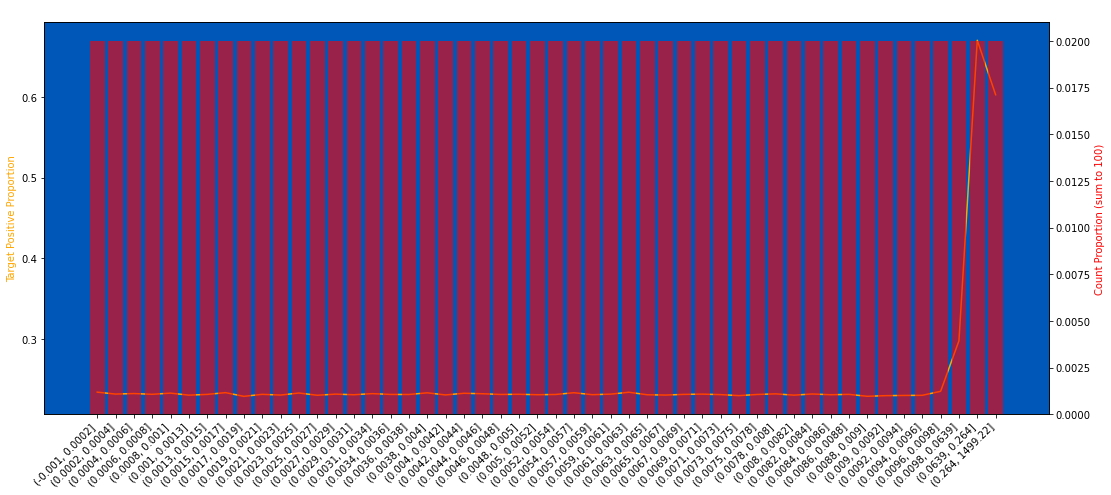

In [101]:
plot_target_check(train, "B_26", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [102]:
train["B_26"] = train["B_26"].round(2)
test["B_26"] = test["B_26"].round(2)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


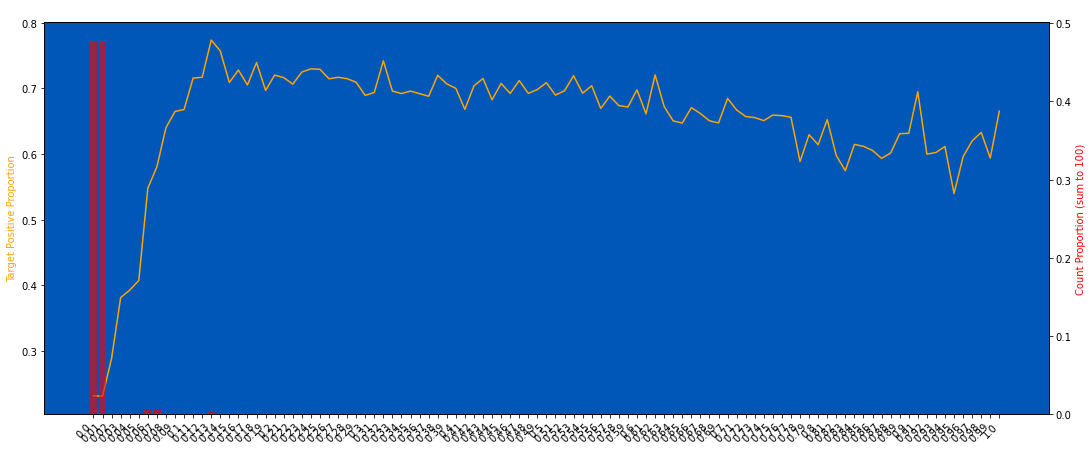

In [103]:
plot_target_check(train, "B_26", q=100, use_raw_bin=True, nunique_thr=35000, strfy_x=True)

### B_27

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


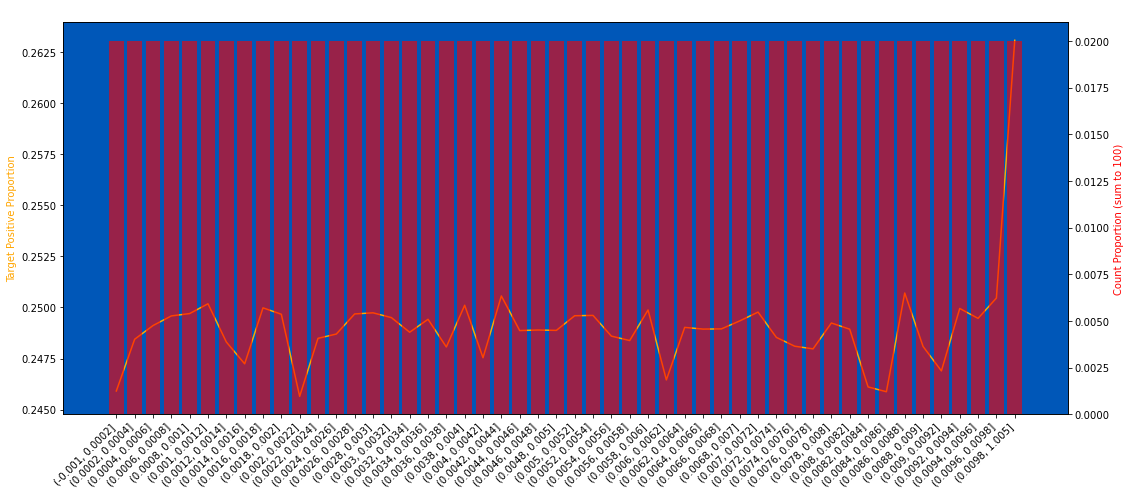

In [104]:
plot_target_check(train, "B_27", q=50, use_raw_bin=True)

In [105]:
train["B_27"] = train["B_27"].round(2)
test["B_27"] = test["B_27"].round(2)

In [106]:
train.loc[train["B_27"].between(-1, 0.01), "B_27"] = 0
test.loc[test["B_27"].between(-1, 0.01), "B_27"] = 0

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


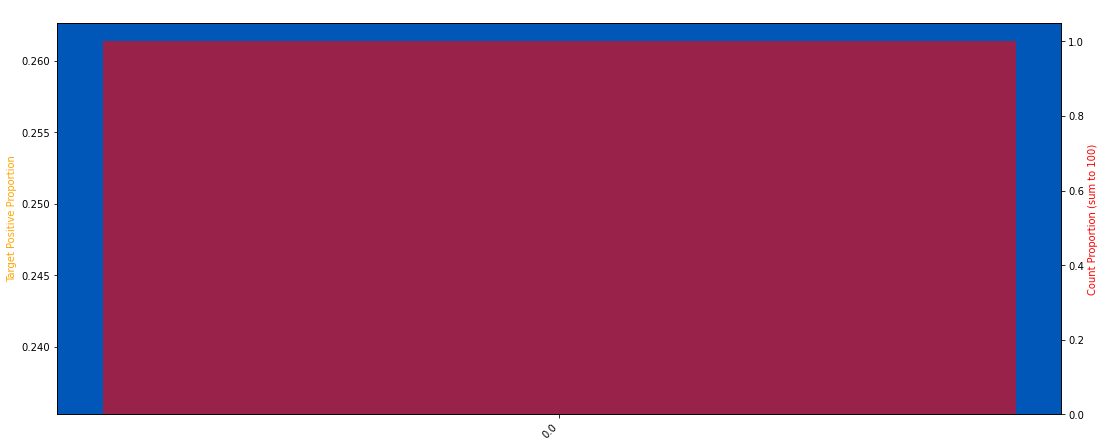

In [107]:
plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [108]:
%time
train = train.drop(columns="B_27", errors="ignore")
test = test.drop(columns="B_27", errors="ignore")

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs


In [109]:
gc.collect()

45076

### B_28

0 null count, 0.000 null proportion
nan of the targets have label = 1


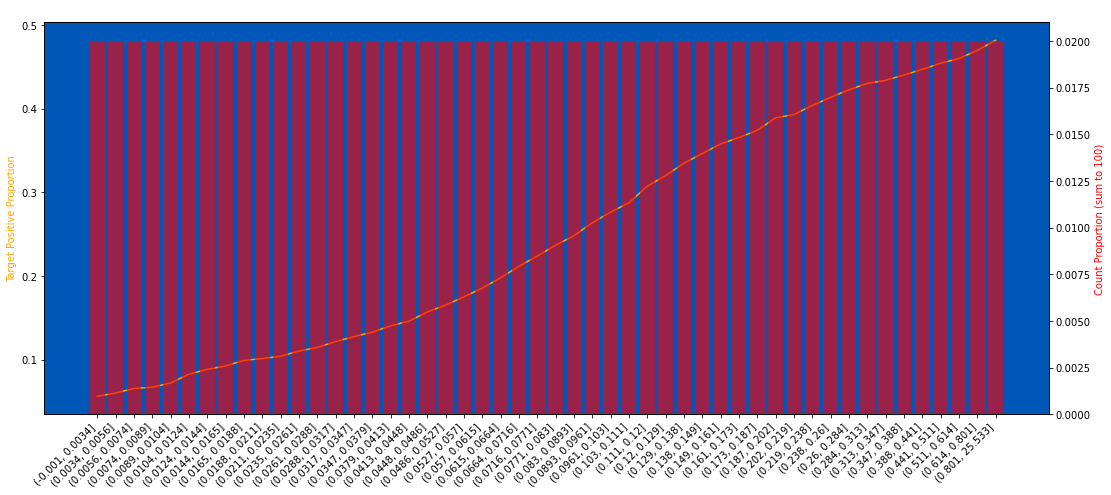

In [110]:
plot_target_check(train, "B_28", q=50, use_raw_bin=True)

In [111]:
train["B_28"] = train["B_28"].round(2)
test["B_28"] = test["B_28"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


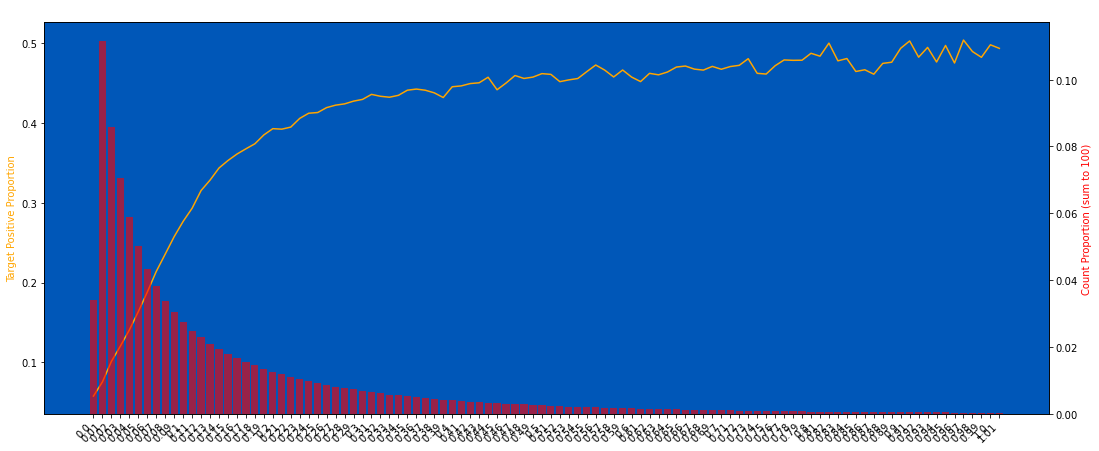

In [112]:
plot_target_check(train, "B_28", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

### B_29

5150035 null count, 0.931 null proportion
0.2512 of the targets have label = 1


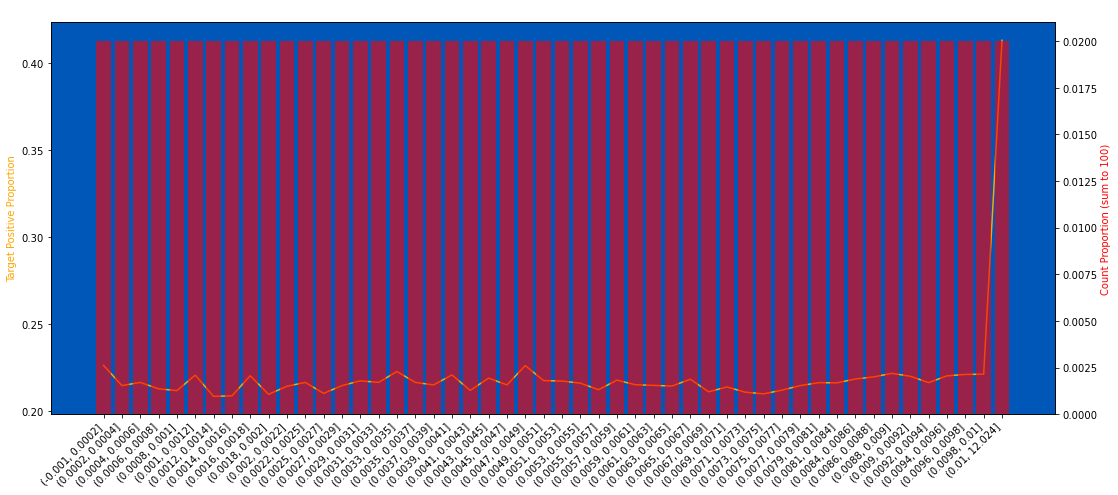

In [113]:
plot_target_check(train, "B_29", q=50, use_raw_bin=True)

In [114]:
train["B_29"] = train["B_29"].round(2)
test["B_29"] = test["B_29"].round(2)

In [115]:
train.loc[train["B_29"].between(-1, 0.01), "B_29"] = np.nan
test.loc[test["B_29"].between(-1, 0.01), "B_29"] = np.nan

5524595 null count, 0.999 null proportion
0.2489 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


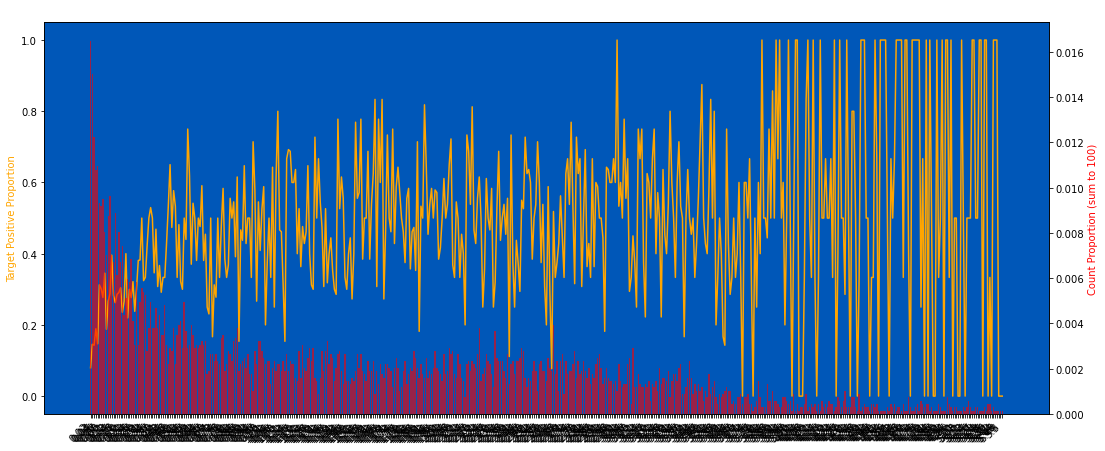

In [116]:
plot_target_check(train, "B_29", q=150, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### B_30

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


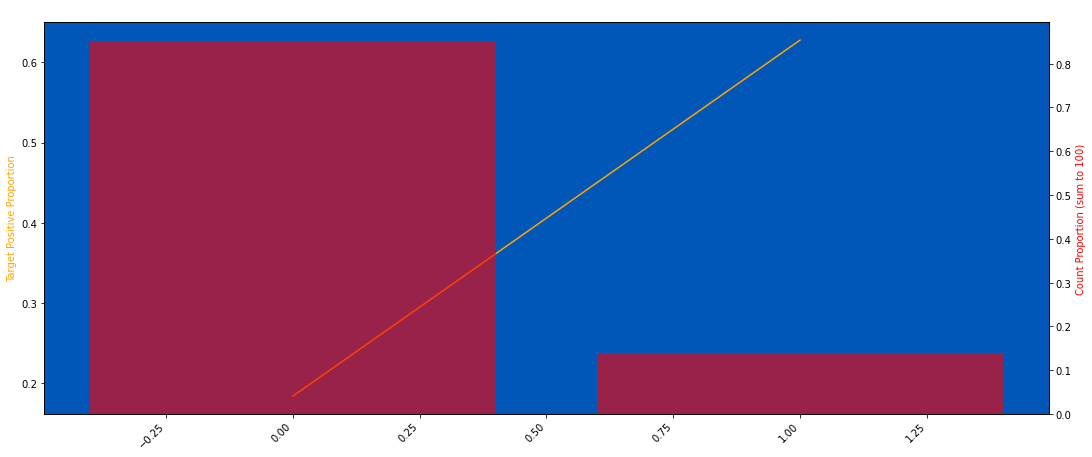

In [117]:
plot_target_check(train, "B_30", q=50, use_raw_bin=True)

### B_31

0 null count, 0.000 null proportion
nan of the targets have label = 1


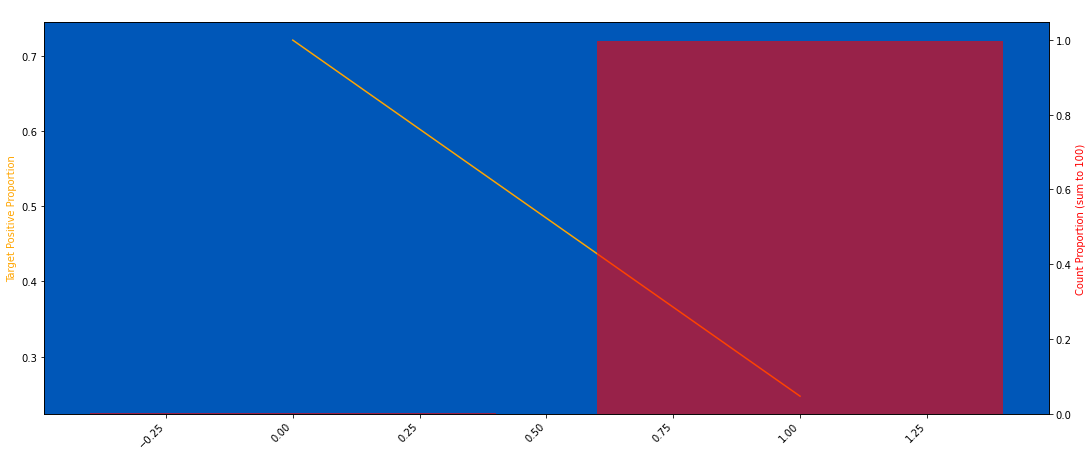

In [118]:
plot_target_check(train, "B_31", q=50, use_raw_bin=True, nunique_thr=3)

### B_32

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


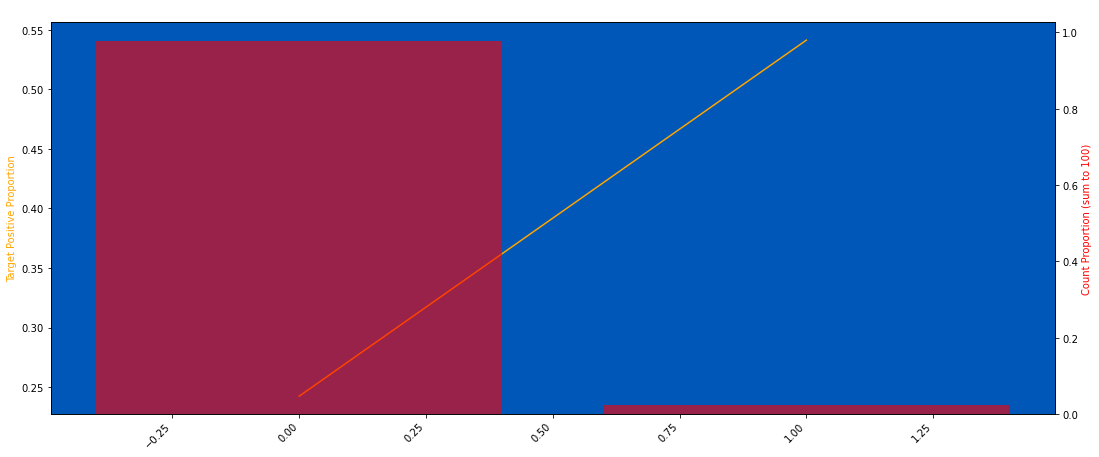

In [119]:
plot_target_check(train, "B_32", q=50, use_raw_bin=True)

### B_33

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


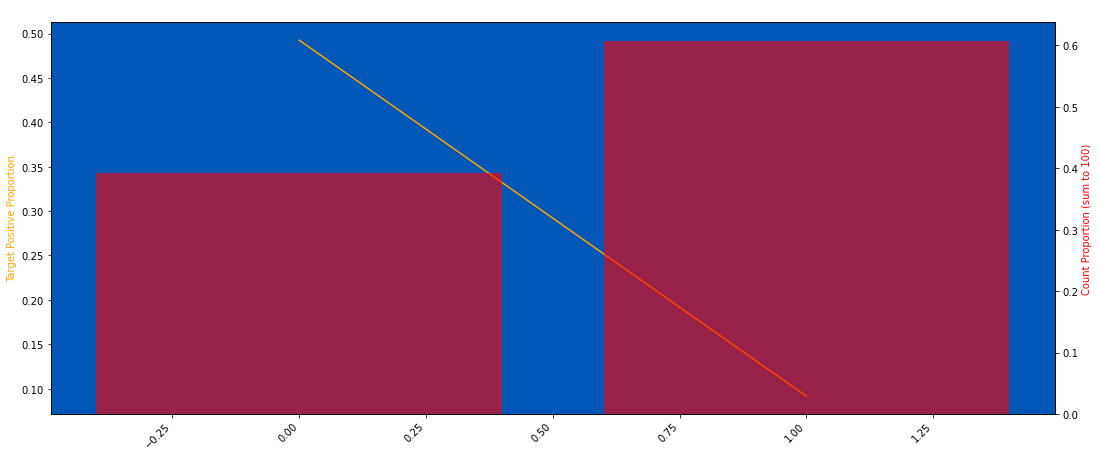

In [120]:
plot_target_check(train, "B_33", q=50, use_raw_bin=True)

### B_36

0 null count, 0.000 null proportion
nan of the targets have label = 1


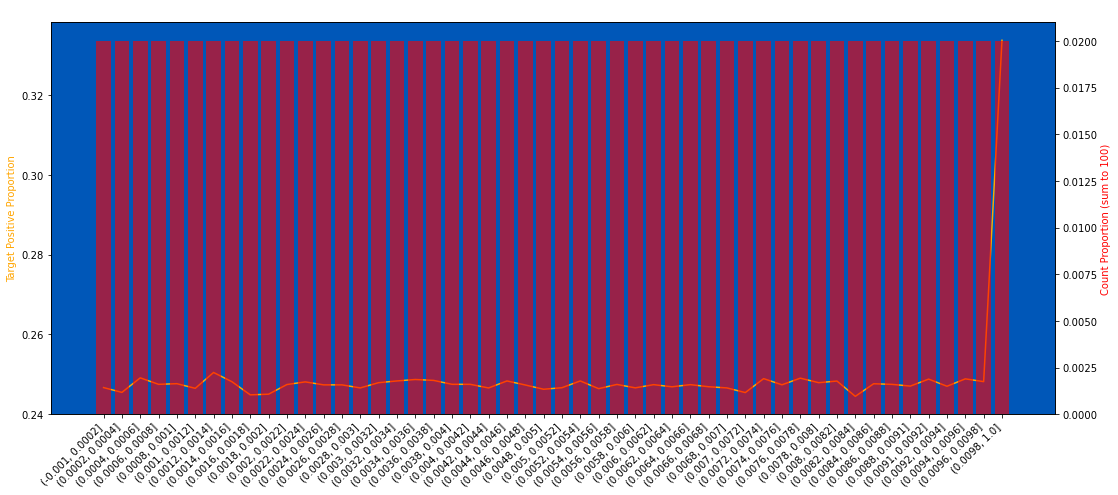

In [121]:
plot_target_check(train, "B_36", q=50, use_raw_bin=True)

In [122]:
train["B_36"] = train["B_36"].round(2)
test["B_36"] = test["B_36"].round(2)

In [123]:
%%time
train.loc[train["B_36"].between(-1, 0.01), "B_36"] = 0
test.loc[test["B_36"].between(-1, 0.01), "B_36"] = 0

CPU times: user 84.5 ms, sys: 77.3 ms, total: 162 ms
Wall time: 93.8 ms


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


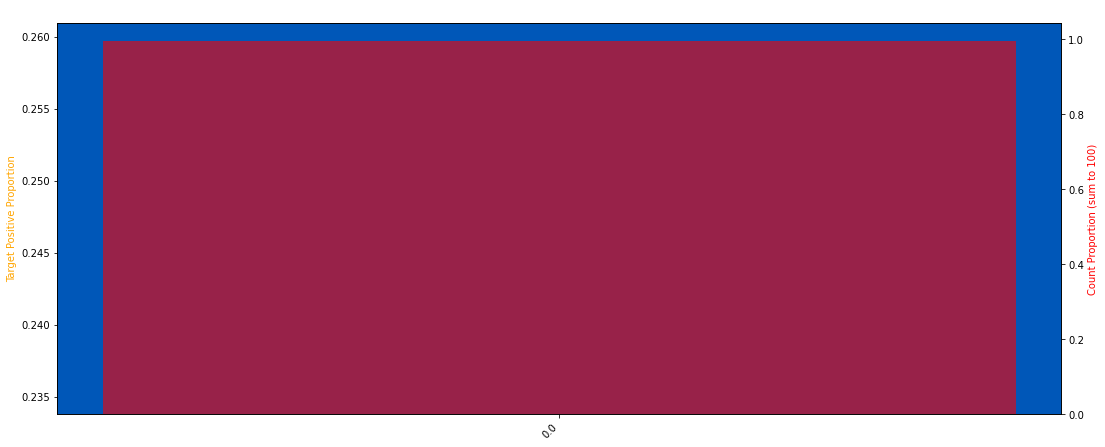

In [124]:
plot_target_check(train, "B_36", q=100, use_raw_bin=True, nunique_thr=500, strfy_x=True)

In [125]:
%time
train = train.drop(columns="B_36", errors="ignore")
test = test.drop(columns="B_36", errors="ignore")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [126]:
gc.collect()

25829

### B_37

56 null count, 0.000 null proportion
0.1964 of the targets have label = 1


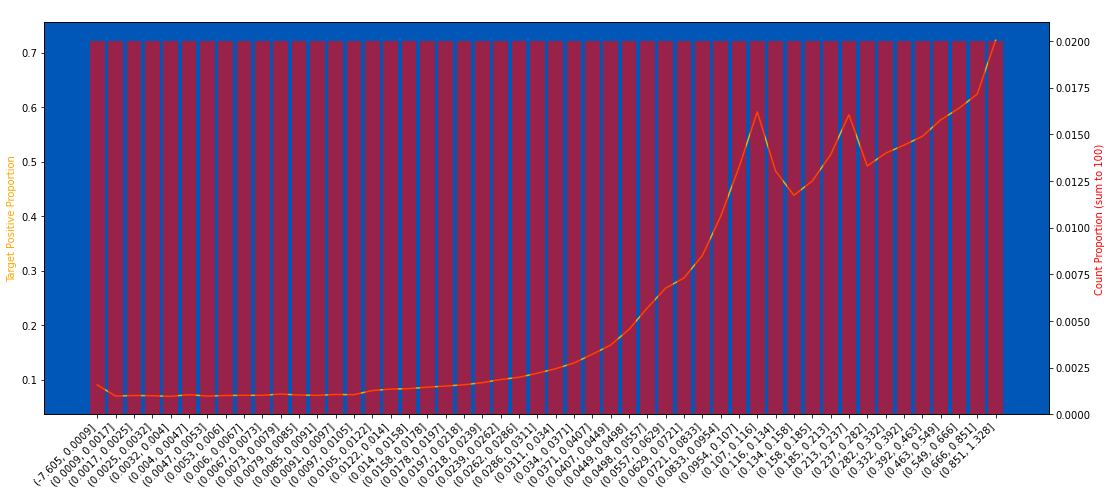

In [127]:
plot_target_check(train, "B_37", q=50, use_raw_bin=True)

In [128]:
train["B_37"] = train["B_37"].round(2)
test["B_37"] = test["B_37"].round(2)

56 null count, 0.000 null proportion
0.1964 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


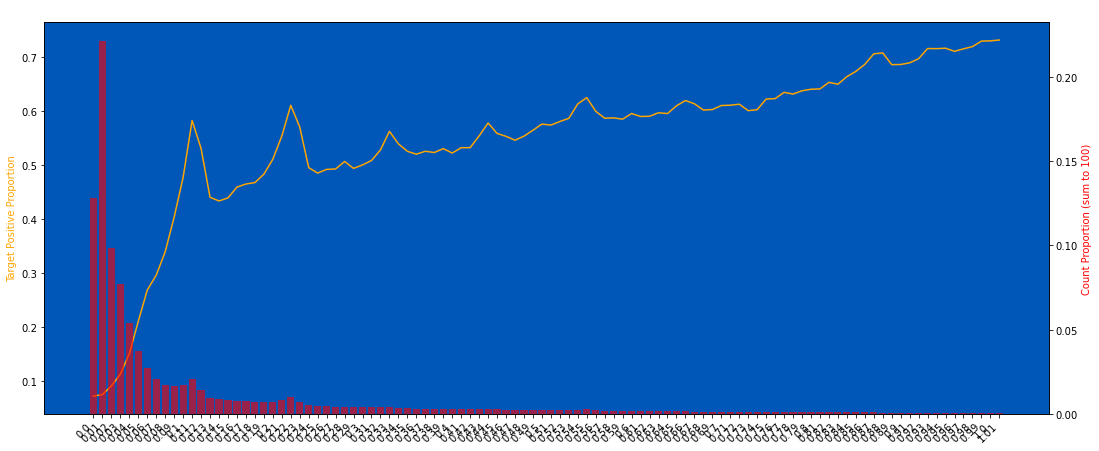

In [129]:
plot_target_check(train, "B_37", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

### B_38

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


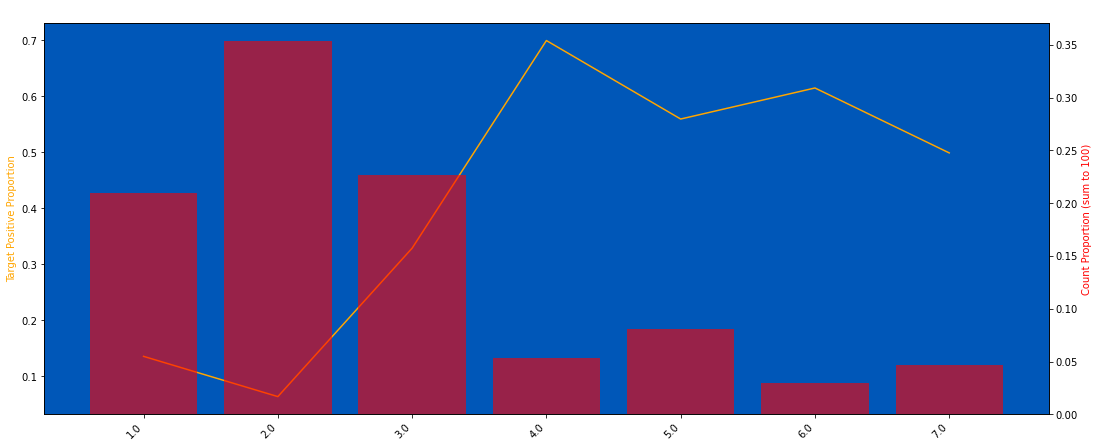

In [130]:
plot_target_check(train, "B_38", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

### B_39

5497819 null count, 0.994 null proportion
0.2473 of the targets have label = 1


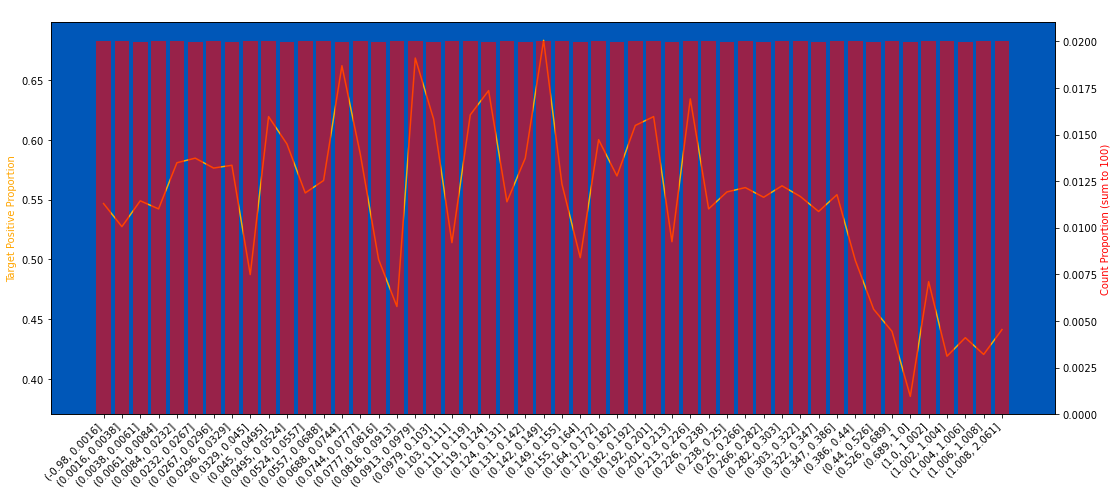

In [131]:
plot_target_check(train, "B_39", q=50, use_raw_bin=True)

In [132]:
train["B_39"] = train["B_39"].round(2)
test["B_39"] = test["B_39"].round(2)

5497819 null count, 0.994 null proportion
0.2473 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


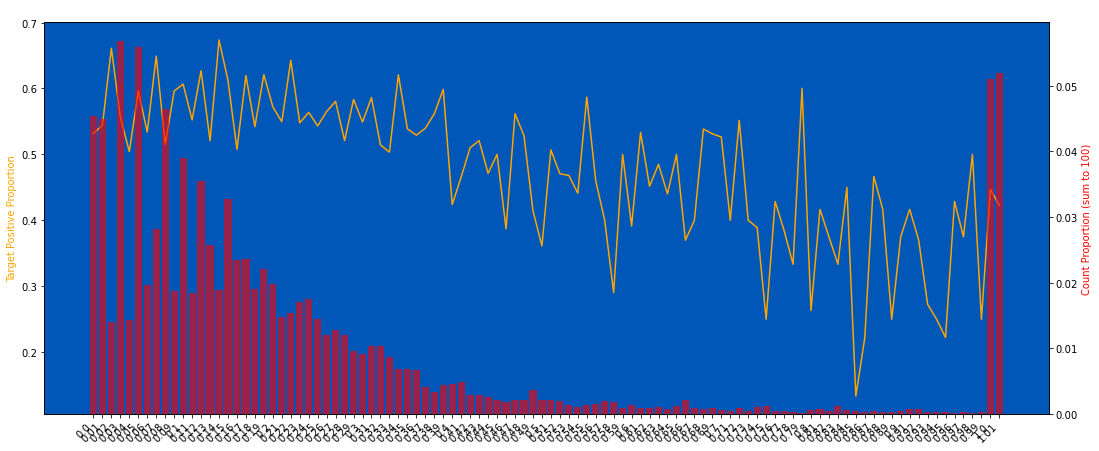

In [133]:
plot_target_check(train, "B_39", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### B_40

53 null count, 0.000 null proportion
0.1698 of the targets have label = 1


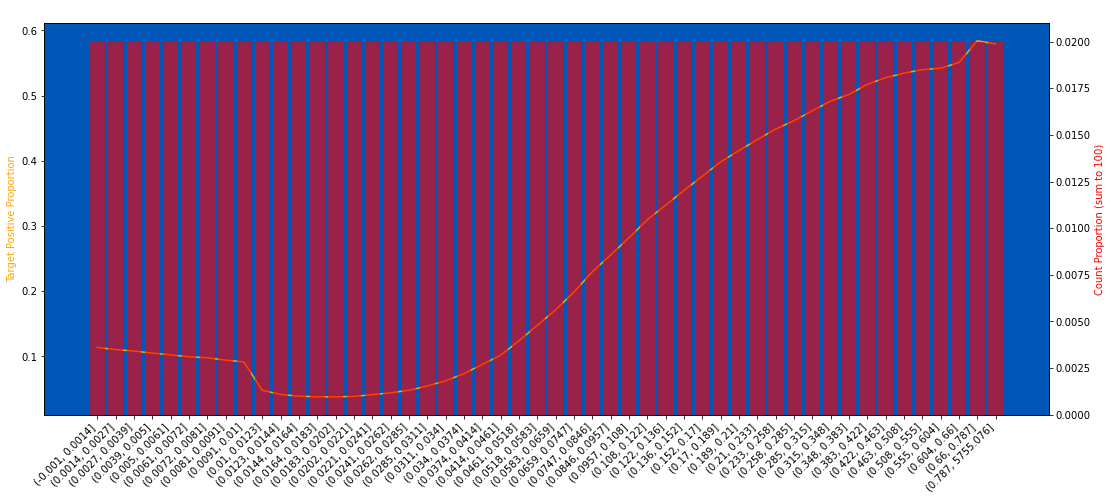

In [134]:
plot_target_check(train, "B_40", q=50, use_raw_bin=True)

In [135]:
train["B_40"] = train["B_40"].round(2)
test["B_40"] = test["B_40"].round(2)

53 null count, 0.000 null proportion
0.1698 of the targets have label = 1


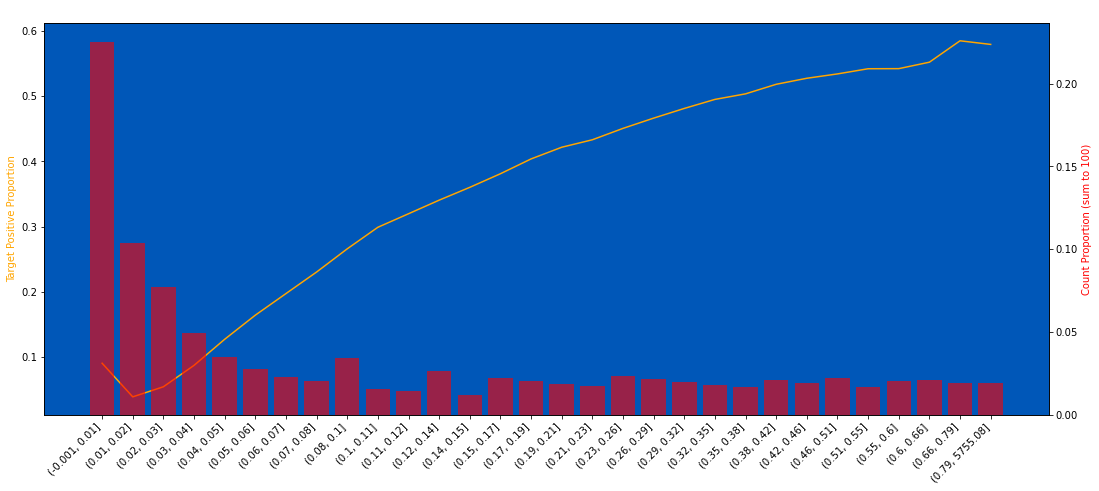

In [136]:
plot_target_check(train, "B_40", q=50, use_raw_bin=True)

In [137]:
%%time
train.loc[train["B_40"].between(-1, 0.02), "B_40"] = np.nan
test.loc[test["B_40"].between(-1, 0.02), "B_40"] = np.nan

CPU times: user 221 ms, sys: 48.8 ms, total: 270 ms
Wall time: 75 ms


1820120 null count, 0.329 null proportion
0.0744 of the targets have label = 1


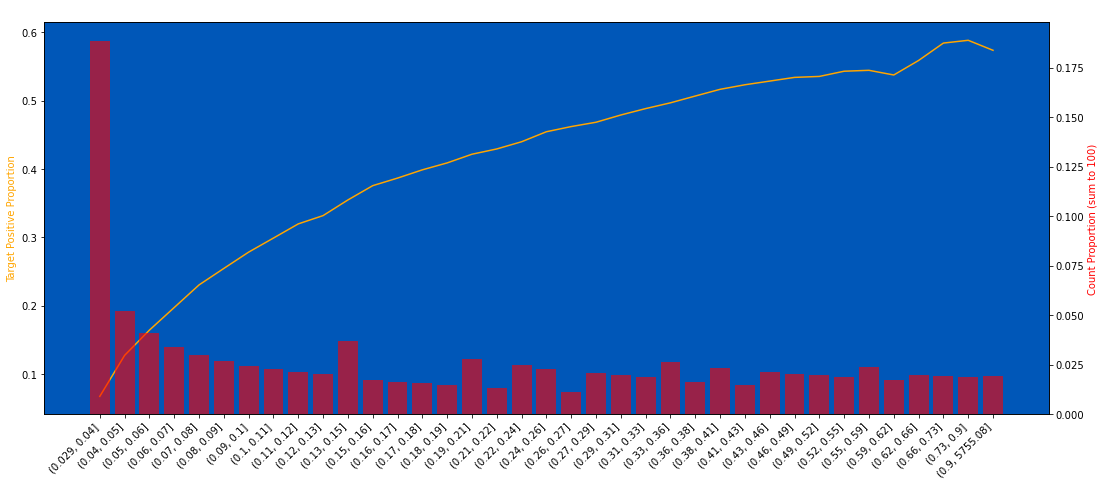

In [138]:
plot_target_check(train, "B_40", q=50, use_raw_bin=True)

### B_41

690 null count, 0.000 null proportion
0.1420 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


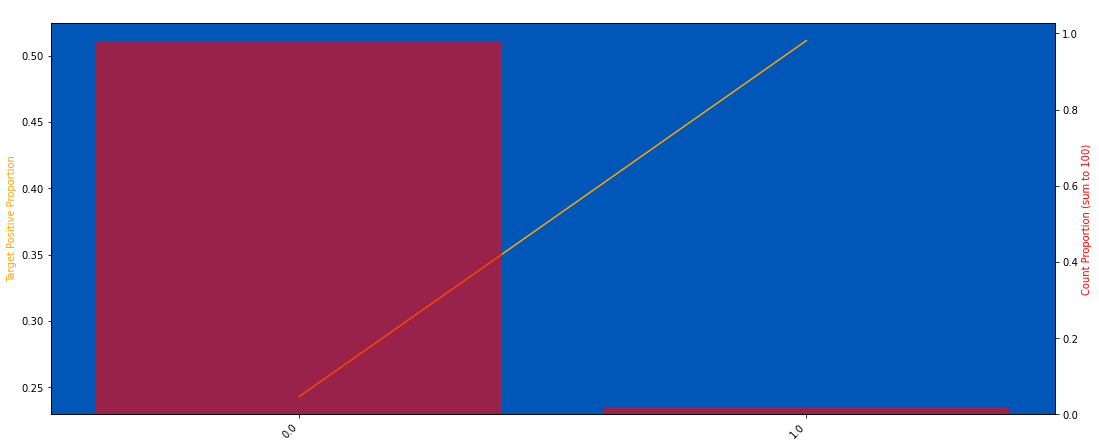

In [139]:
plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


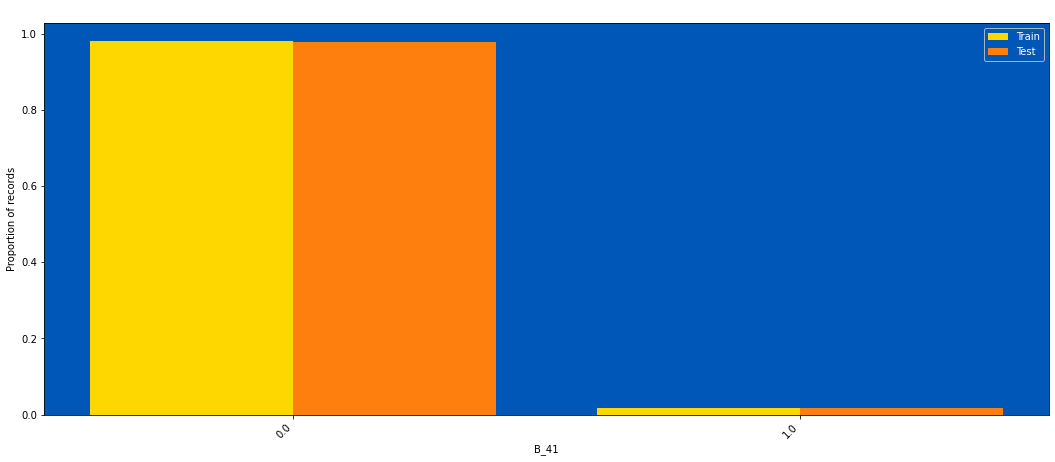

In [140]:
plot_train_test_distribution(train, test, "B_41", nunique_thr=100)

### B_42

5459973 null count, 0.987 null proportion
0.2508 of the targets have label = 1


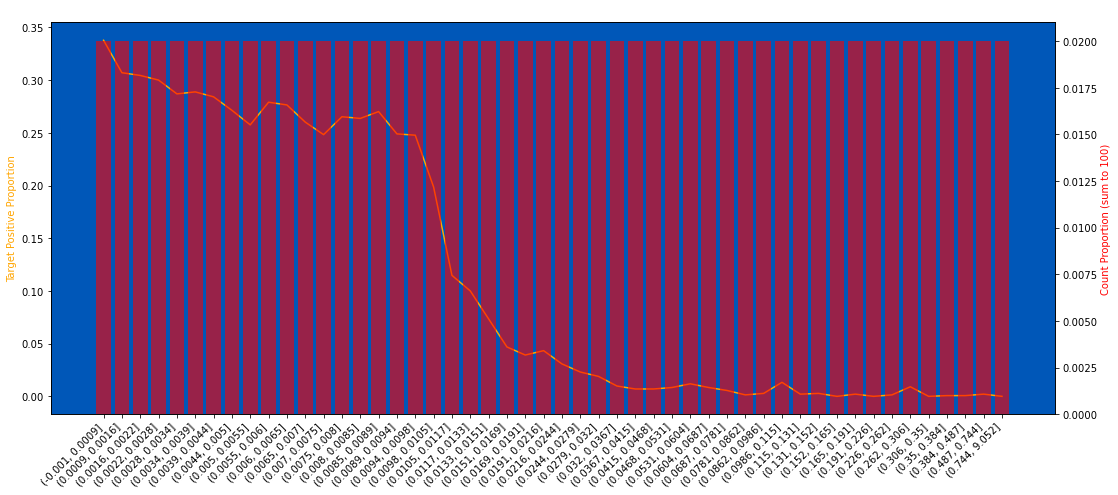

In [141]:
plot_target_check(train, "B_42", q=50, use_raw_bin=True)

In [142]:
train["B_42"] = train["B_42"].round(2)
test["B_42"] = test["B_42"].round(2)

5459973 null count, 0.987 null proportion
0.2508 of the targets have label = 1


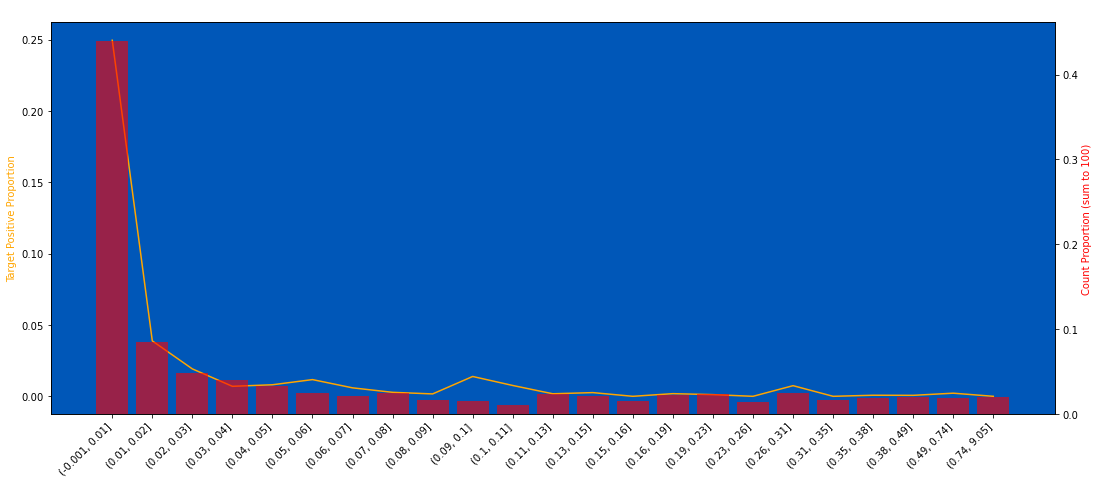

In [143]:
plot_target_check(train, "B_42", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


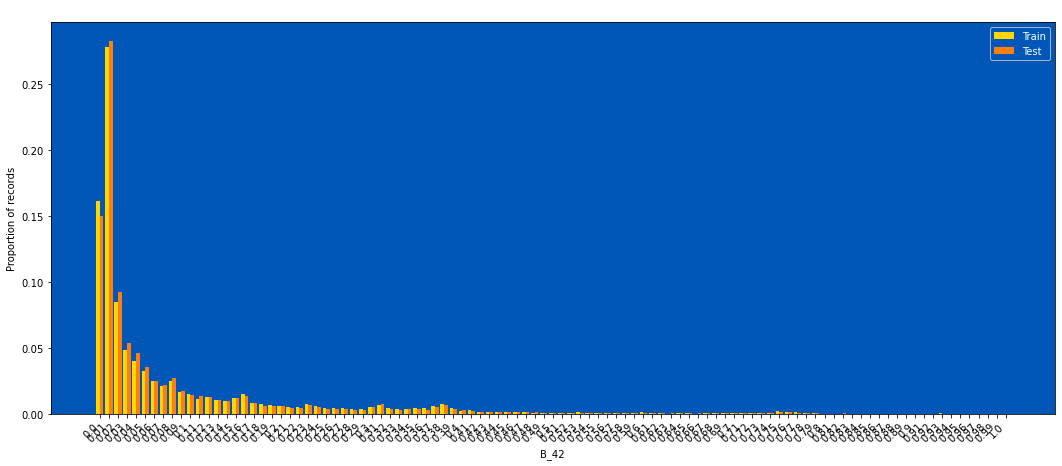

In [144]:
plot_train_test_distribution(train, test, "B_42", nunique_thr=300)

In [145]:
train = train.drop(columns=["temp"], errors="ignore")
test = test.drop(columns=["temp"], errors="ignore")

### Column checking

In [146]:
all_columns = get_cols(train, "B_")

In [147]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -1, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-1, -999)
    neg1_series = test.loc[test[d] == -1, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-1, -999)

 26%|███████████████████████████████████                                                                                                  | 10/38 [00:00<00:00, 46.89it/s]

Test B_14 2
Test B_15 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 12.78it/s]


In [148]:
d_col_nunique = train[all_columns].nunique()

In [149]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 64].index.tolist()

In [150]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

B_8 : float32 
 [0.0, 1.0, nan] 

B_16 : float64 
 [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan] 

B_18 : float32 
 [0.0, 0.009999999776482582, 0.019999999552965164, 0.05000000074505806, 0.05999999865889549, 0.07000000029802322, 0.07999999821186066, 0.09000000357627869, 0.10000000149011612, 0.11999999731779099, 0.12999999523162842, 0.14000000059604645, 0.15000000596046448, 0.1599999964237213, 0.17000000178813934, 0.18000000715255737, 0.1899999976158142, 0.20000000298023224, 0.20999999344348907, 0.2199999988079071, 0.23000000417232513, 0.23999999463558197, 0.25, 0.25999999046325684, 0.27000001072883606, 0.28999999165534973, 0.30000001192092896, 0.3100000023841858, 0.3199999928474426, 0.33000001311302185, 0.3400000035762787, 0.3499999940395355, 0.36000001430511475, 0.3700000047683716, 0.3799999952316284, 0.4000000059604645, 0.4099999964237213, 0.41999998688697815, 0.4300000071525574, 0.4399999976158142, 0.44999998807907104, 0.46000000834465027, 0.4699999988079

In [151]:
# for d in tqdm(train.columns):
#     train[d] = train[d].fillna(-127)
#     test[d] = test[d].fillna(-127)

In [152]:
for col in tqdm(less_unique_d_cols):
    train[col] = integerize(train[col])
    test[col] = integerize(test[col])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.35s/it]


In [153]:
%%time
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

CPU times: user 1.64 s, sys: 6.96 s, total: 8.6 s
Wall time: 13.4 s


In [154]:
train.shape, test.shape

((5531451, 191), (11363762, 190))

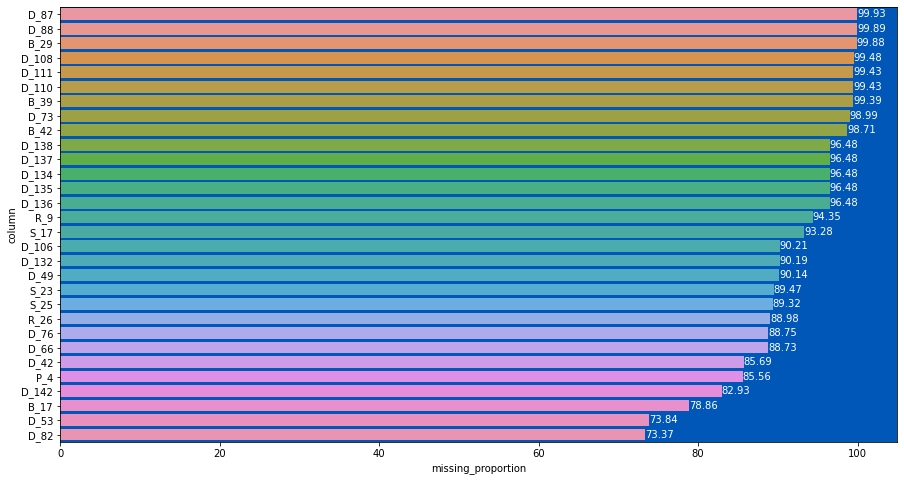

In [155]:
missing_df = plot_missing_proportion_barchart(train)

In [156]:
%%time
train.to_parquet(f"{RAW_TRAIN_PARQUET_PATH}/train_psrb.parquet")
test.to_parquet(f"{RAW_TEST_PARQUET_PATH}/test_psrb.parquet")

CPU times: user 45.4 s, sys: 7.65 s, total: 53 s
Wall time: 46.8 s


In [157]:
END = time.time()

In [160]:
print(f"{END - START:.2f} seconds elapsed")

375.12 seconds elapsed
